# Google Analytics Customer Revenue - Regression

## 1. Imports

### 1.1. Libraries

In [96]:
import sys
import os
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

pd.options.display.max_rows = 100
plt.style.use('ggplot')

import matplotlib.pyplot as plt

from sklearn import model_selection
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn import set_config

from scipy import stats
from datetime import datetime

import random
import json
from pandas import json_normalize

from xml.etree.ElementInclude import include

### 1.2. Data

In [97]:
## Función de lectura 
columns = ['device', 'geoNetwork', 'totals'] # Columns with json format

p = 0.1 # Fraction of data to use

def json_read(df):
    data_frame = fire_dir + df
    
    df = pd.read_csv(data_frame, 
                     #converts json object into something readable by Python (whatever is in "dict" is a column)
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'}, 
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in columns: 
      #converts each column
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df

In [98]:
RANDOM_STATE = 42
fire_dir = r'C:\Users\Usuario\Desktop\Proyects\Machine Learning\data'
file_name = r'\GACR_def.csv'

data_frame = fire_dir + file_name
p = 0.1 # Fracción de datos a utilizar

In [99]:
%%time
random.seed(RANDOM_STATE)
df = json_read(file_name)

Loaded GACR_def.csv. Shape: (90249, 42)
CPU times: total: 6.14 s
Wall time: 10.6 s


### 1.3. Functions

In [100]:
def data_preparation(df):
    df.set_index('sessionId', inplace = True)
    df_ids = ['fullVisitorId', 'visitId', 'Unnamed: 0']
    df.drop(df_ids, axis = 1, inplace =True)
    constant_columns = [column for column in df.columns if df[column].nunique(dropna = False) == 1]
    df.drop(constant_columns, axis = 1, inplace = True)
    return df


def target_prep(df):
    TARGET = 'totals.transactionRevenue'
    df[TARGET]= df[TARGET].astype(float)
    df[TARGET].fillna(0.0, inplace =  True)
    df[TARGET] =df[TARGET]/1000000
    df['visitWithTransaction'] = (df[TARGET]>0).astype(int)
    df['totals.transactionRevenueLOG'] = df[TARGET].apply(lambda x: np.log1p(x))
    TARGET_LOG = 'totals.transactionRevenueLOG'
    return df

def plot_cat_values(dataframe, column, target_column):
    plt.figure(figsize=(15,8))
    #en una única grafica de 2x1 en el primer slot
    ax1 = plt.subplot(2,1,1)
    ## Graficamos el conteo de cada uno de los valores
    ax1 = sns.countplot(
        data = dataframe, x = column,
        order = list(dataframe[column].unique())
    )
    ax2 = plt.subplot(2,1,2) # share ax1 para que me pinte el axis en el mismo orden
    ## Graficamos la distribución del target sólo para aquellos casos con target > 0 (para que no se chafe el BP) 
    ax2 = sns.boxenplot(
        data = dataframe[dataframe[target_column] > 0], 
        x = column,
        y = target_column,
        order = list(dataframe[column].unique())
    )
    plt.show()

def explore_cat_values(dataframe, column, target_column):
    _results_df = dataframe[dataframe[target_column] > 1].pivot_table(index=column, values=target_column, aggfunc=[len, np.mean])
    _results_df.columns = ['transactions', 'mean_revenue_ln']
    _results_df['n_rows'] = dataframe[column].value_counts(dropna=False)
    _results_df['pct_rows'] = dataframe[column].value_counts(normalize=True, dropna=False).round(3)
    _results_df['pct_transactions'] = (_results_df['transactions'] / _results_df['n_rows']).round(3)
    _results_df = _results_df[['n_rows', 'pct_rows', 'transactions', 'pct_transactions', 'mean_revenue_ln']]
    return _results_df

def cat_analysis(dataframe, col, target_col):
    print(dataframe[col].value_counts())
    plot_cat_values(dataframe,col, target_col )
    return explore_cat_values(dataframe, col, target_col)

def plot_num_values(dataframe, column, target_column):

  plt.figure(figsize= (20,8))

  ax1 = plt.subplot(2,1,1)
  ax1 = sns.regplot(data = dataframe, x = column, y = target_column)

  ax2 = plt.subplot(2,1,2)
  ax2 = sns.lineplot(data = dataframe, x= column, y = target_column)
  plt.show()

def date_prep(df, col_date):
    df[col_date] = pd.to_datetime(df[col_date], format = '%Y%m%d')
    df['year'] = df[col_date].dt.year
    df['month'] = df[col_date].dt.month
    df['monthDay'] = df[col_date].dt.day
    df['weekDay'] = df[col_date].dt.weekday
    df['quarter'] = df[col_date].dt.quarter
    df['week'] = df[col_date].dt.week
    return df.drop(col_date, axis=1, inplace=True)

def setOthers(dataframe, column, num_values):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

def setOthersminmax(dataframe, column, target_column, num_rows_min, top_n):
    results_by_category = explore_cat_values(dataframe, column, target_column)
    last_categories = results_by_category[results_by_category['n_rows'] > num_rows_min].sort_values(by='pct_transactions').head(top_n).index.to_list()
    first_categories = results_by_category[results_by_category['n_rows'] > num_rows_min].sort_values(by='pct_transactions').tail(top_n).index.to_list()
    top_categories_list = list(set(first_categories + last_categories))
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

## 2. Data Understanding

### 2.1. Univariant Analysis

In [101]:
df.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90249 entries, 0 to 90248
Columns: 42 entries, Unnamed: 0 to totals.transactionRevenue
dtypes: bool(1), int64(5), object(36)
memory usage: 28.3+ MB


In [102]:
df.head(3).T

,0,1,2
Unnamed: 0,1,7,9
channelGrouping,Organic Search,Organic Search,Organic Search
date,20160902,20160902,20160902
fullVisitorId,377306020877927890,537222803633850821,9499785259412240342
sessionId,377306020877927890_1472880147,537222803633850821_1472812602,9499785259412240342_1472812272
socialEngagementType,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
visitId,1472880147,1472812602,1472812272
visitNumber,1,1,1
visitStartTime,1472880147,1472812602,1472812272
device.browser,Firefox,Chrome,Firefox


In [103]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,90249.0,4.517847e+05,2.613238e+05,1.000000e+00,2.254420e+05,4.512880e+05,6.777830e+05,9.036510e+05
date,90249.0,2.016587e+07,4.697879e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitId,90249.0,1.484998e+09,9.021906e+06,1.470039e+09,1.477560e+09,1.483901e+09,1.492727e+09,1.501657e+09
visitNumber,90249.0,2.241920e+00,8.800759e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.930000e+02
visitStartTime,90249.0,1.484998e+09,9.021906e+06,1.470039e+09,1.477560e+09,1.483901e+09,1.492727e+09,1.501657e+09


In [104]:
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90249,8,Organic Search,37993
fullVisitorId,90249,85739,1957458976293878100,26
sessionId,90249,90242,6655979485478527103_1477465197,2
socialEngagementType,90249,1,Not Socially Engaged,90249
device.browser,90249,32,Chrome,62130
device.browserVersion,90249,1,not available in demo dataset,90249
device.browserSize,90249,1,not available in demo dataset,90249
device.operatingSystem,90249,14,Windows,34835
device.operatingSystemVersion,90249,1,not available in demo dataset,90249
device.isMobile,90249,2,False,66496


In [105]:
df = data_preparation(df)
df

,channelGrouping,date,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue
sessionId,,,,,,,,,,,,,,,,,,,,
377306020877927890_1472880147,Organic Search,20160902,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,1,1,NaN
537222803633850821_1472812602,Organic Search,20160902,1,1472812602,Chrome,Windows,False,desktop,Oceania,Australasia,Australia,Queensland,(not set),Brisbane,bigpond.net.au,1,1,1,1,NaN
9499785259412240342_1472812272,Organic Search,20160902,1,1472812272,Firefox,Windows,False,desktop,Europe,Western Europe,Netherlands,not available in demo dataset,not available in demo dataset,not available in demo dataset,chello.nl,1,1,1,1,NaN
357659889600827884_1472839882,Organic Search,20160902,1,1472839882,Safari,iOS,True,mobile,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,unknown.unknown,1,1,1,1,NaN
3696906537737368442_1472856874,Organic Search,20160902,1,1472856874,Chrome,Windows,False,desktop,Americas,South America,Argentina,Buenos Aires,(not set),Buenos Aires,phonevision.com.ar,1,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533119567408419467_1483573456,Social,20170104,1,1483573456,Opera Mini,Android,True,mobile,Europe,Eastern Europe,Ukraine,not available in demo dataset,not available in demo dataset,not available in demo dataset,umc.net.ua,3,3,NaN,1,NaN
0617024530428033097_1483561021,Social,20170104,1,1483561021,Chrome,Windows,False,desktop,Americas,Northern America,Canada,Ontario,(not set),Toronto,cogentco.com,3,3,NaN,1,NaN
469840327005431380_1483573235,Social,20170104,1,1483573235,Internet Explorer,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),9,9,NaN,1,NaN


In [106]:
#df_description = df.describe(include = 'all').T
#df_description.to_csv('GACR_description.csv')
#print("Archivo guardado en:", os.path.abspath('GACR_description.csv'))

### 2.1.1. Target

In [107]:
df = target_prep(df)

In [108]:
print('De las {} visitas, hay {} con compras, lo que significa que el {} por ciento de las visitas tienen compra'.format(
    df['visitWithTransaction'].count(),
    df['visitWithTransaction'].sum(),
    round(df['visitWithTransaction'].mean() * 100, 2)
))

De las 90249 visitas, hay 1177 con compras, lo que significa que el 1.3 por ciento de las visitas tienen compra


In [109]:
df.T

sessionId,377306020877927890_1472880147,537222803633850821_1472812602,9499785259412240342_1472812272,357659889600827884_1472839882,3696906537737368442_1472856874,3293772317640873624_1472808002,1283542838194038522_1472885255,1397786681184924394_1472822131,0715569826025005549_1472864193,3746051970600816343_1472843059,...,8373534673721431984_1483520539,43021114707905908_1483543163,271411582534610181_1483553982,968018605052053571_1483560541,3591531861629139100_1483535166,533119567408419467_1483573456,0617024530428033097_1483561021,469840327005431380_1483573235,5744576632396406899_1483526434,2709355455991750775_1483592857
channelGrouping,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Referral,...,Social,Social,Social,Social,Social,Social,Social,Social,Social,Social
date,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,20160902,...,20170104,20170104,20170104,20170104,20170104,20170104,20170104,20170104,20170104,20170104
visitNumber,1,1,1,1,1,1,1,1,1,2,...,1,1,1,1,2,1,1,1,1,1
visitStartTime,1472880147,1472812602,1472812272,1472839882,1472856874,1472808002,1472885255,1472822131,1472864193,1472843059,...,1483520539,1483543163,1483553982,1483560541,1483535166,1483573456,1483561021,1483573235,1483526434,1483592864
device.browser,Firefox,Chrome,Firefox,Safari,Chrome,Firefox,Safari,Chrome,Chrome,Chrome,...,YaBrowser,Edge,Chrome,Chrome,Chrome,Opera Mini,Chrome,Internet Explorer,Android Webview,Chrome
device.operatingSystem,Macintosh,Windows,Windows,iOS,Windows,Windows,Macintosh,Android,Windows,Linux,...,Windows,Windows,Windows,Windows,Macintosh,Android,Windows,Windows,Android,Windows
device.isMobile,False,False,False,True,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,False
device.deviceCategory,desktop,desktop,desktop,mobile,desktop,desktop,desktop,mobile,desktop,desktop,...,desktop,desktop,desktop,desktop,desktop,mobile,desktop,desktop,mobile,desktop
geoNetwork.continent,Oceania,Oceania,Europe,Asia,Americas,Europe,Europe,Europe,Americas,Americas,...,Europe,Europe,Americas,Americas,Europe,Europe,Americas,Europe,Asia,Asia
geoNetwork.subContinent,Australasia,Australasia,Western Europe,Western Asia,South America,Western Europe,Eastern Europe,Northern Europe,South America,Northern America,...,Eastern Europe,Eastern Europe,Central America,South America,Northern Europe,Eastern Europe,Northern America,Western Europe,Eastern Asia,Southeast Asia


In [110]:
df['totals.transactionRevenue'].isnull().sum()

0

In [111]:
TARGET = 'totals.transactionRevenue'
TARGET_LOG = 'totals.transactionRevenueLOG'

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2790675666.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2790675666.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


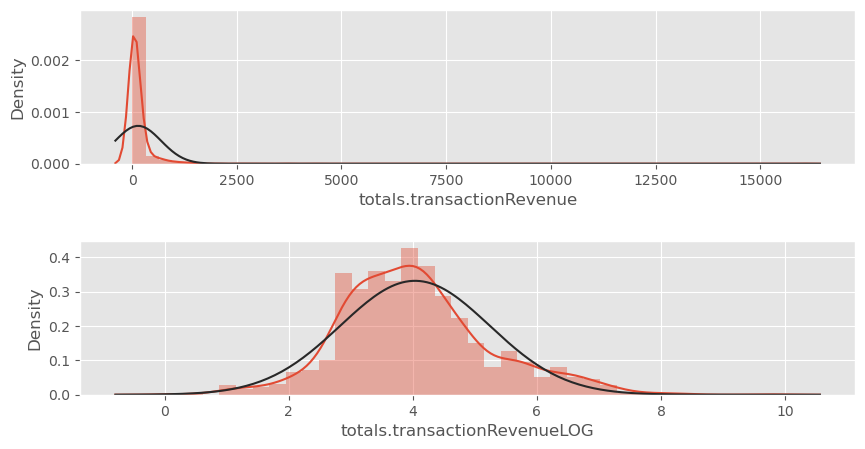

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

sns.distplot(
    df[df['visitWithTransaction']==1][TARGET],
    fit=stats.norm,
    ax=ax1
)

sns.distplot(
    df[df['visitWithTransaction']==1][TARGET_LOG],
    fit=stats.norm,
    ax=ax2
)

plt.subplots_adjust(hspace=0.5)
plt.show()

### 2.1.4. Nulls

In [113]:
df.isnull().sum()

channelGrouping                     0
date                                0
visitNumber                         0
visitStartTime                      0
device.browser                      0
device.operatingSystem              0
device.isMobile                     0
device.deviceCategory               0
geoNetwork.continent                0
geoNetwork.subContinent             0
geoNetwork.country                  0
geoNetwork.region                   0
geoNetwork.metro                    0
geoNetwork.city                     0
geoNetwork.networkDomain            0
totals.hits                         0
totals.pageviews                   13
totals.bounces                  45119
totals.newVisits                20259
totals.transactionRevenue           0
visitWithTransaction                0
totals.transactionRevenueLOG        0
dtype: int64

In [114]:
set_config(transform_output = "pandas")

In [115]:
null_imputer = ColumnTransformer(
    transformers=[
        ('imputezero', SimpleImputer(strategy='constant', fill_value='0'), ['totals.bounces', 'totals.newVisits']),
        ('pageviews_imputer', SimpleImputer(strategy='most_frequent'), ['totals.pageviews'])
    ]
)
df[['totals.bounces', 'totals.newVisits', 'totals.pageviews']] = null_imputer.fit_transform(df)


## 2.2. Bivariant analysis

### 2.2.1. Date & Visit Start Time

In [116]:
#df['date'].describe()
#df['date'].head()
#df['visitStartTime'].describe()
#df['visitStartTime'].head()

In [117]:
date_prep(df, 'date')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\4141505615.py:71: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df[col_date].dt.week


11    11304
10     9803
12     8037
8      7683
7      7138
9      7134
3      6878
4      6598
5      6539
1      6506
6      6403
2      6226
Name: month, dtype: int64


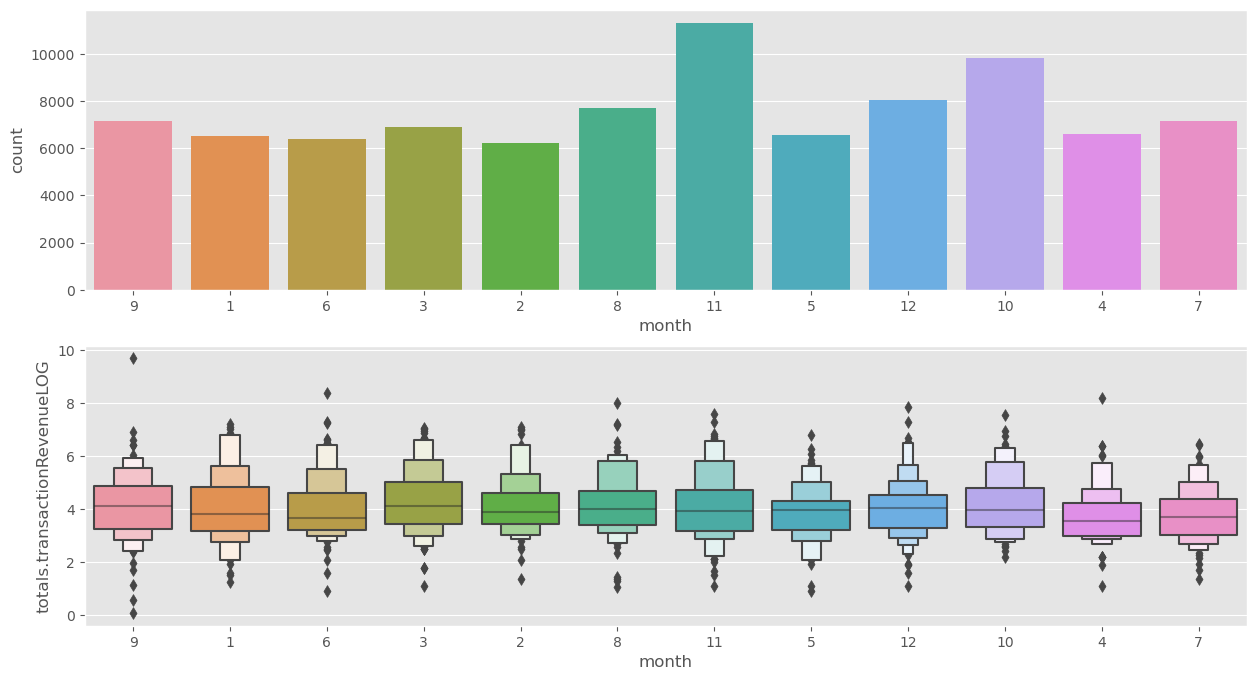

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
month,,,,,
1,6506,0.072,80,0.012,4.037612
2,6226,0.069,78,0.013,4.115831
3,6878,0.076,101,0.015,4.279194
4,6598,0.073,80,0.012,3.738462
5,6539,0.072,98,0.015,3.901971
6,6403,0.071,103,0.016,4.052754
7,7138,0.079,96,0.013,3.785148
8,7683,0.085,102,0.013,4.142930
9,7134,0.079,97,0.014,4.186442


In [118]:
cat_analysis(df, 'month', TARGET_LOG)


In [119]:
explore_cat_values(df, 'year', TARGET)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
year,,,,,
2016,43696,0.484,535,0.012,161.114729
2017,46553,0.516,640,0.014,132.307078


In [120]:
df['visitHour'] = df['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)
df.drop('visitStartTime', axis = 1, inplace = True)

<Axes: >

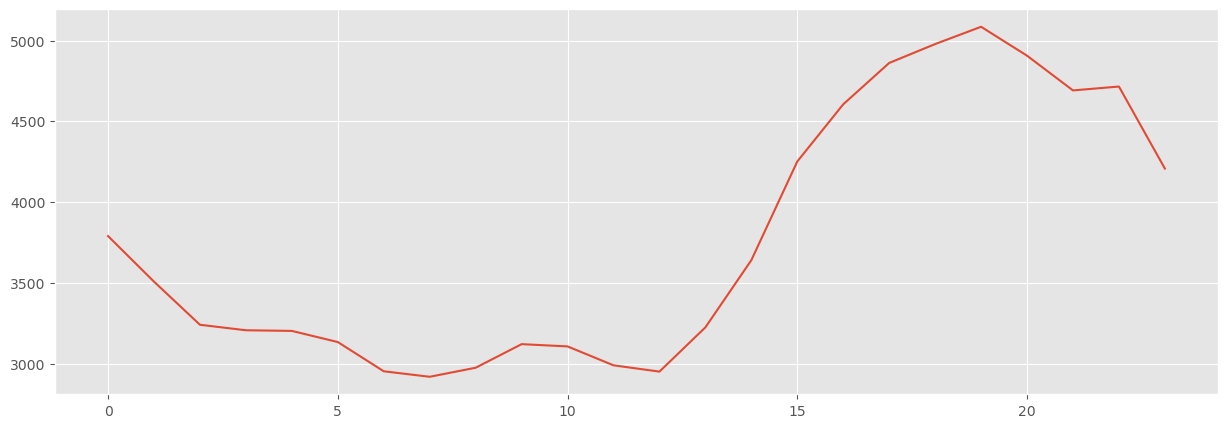

In [121]:
df['visitHour'].value_counts().sort_index().plot(figsize = (15, 5))

### 2.2.2. Boolean

In [122]:
cols_to_int = ['device.isMobile', 'totals.hits', 'totals.pageviews']
df[cols_to_int] = df[cols_to_int].astype(int)

#### 2.2.2.1. Is Mobile

0    66496
1    23753
Name: device.isMobile, dtype: int64


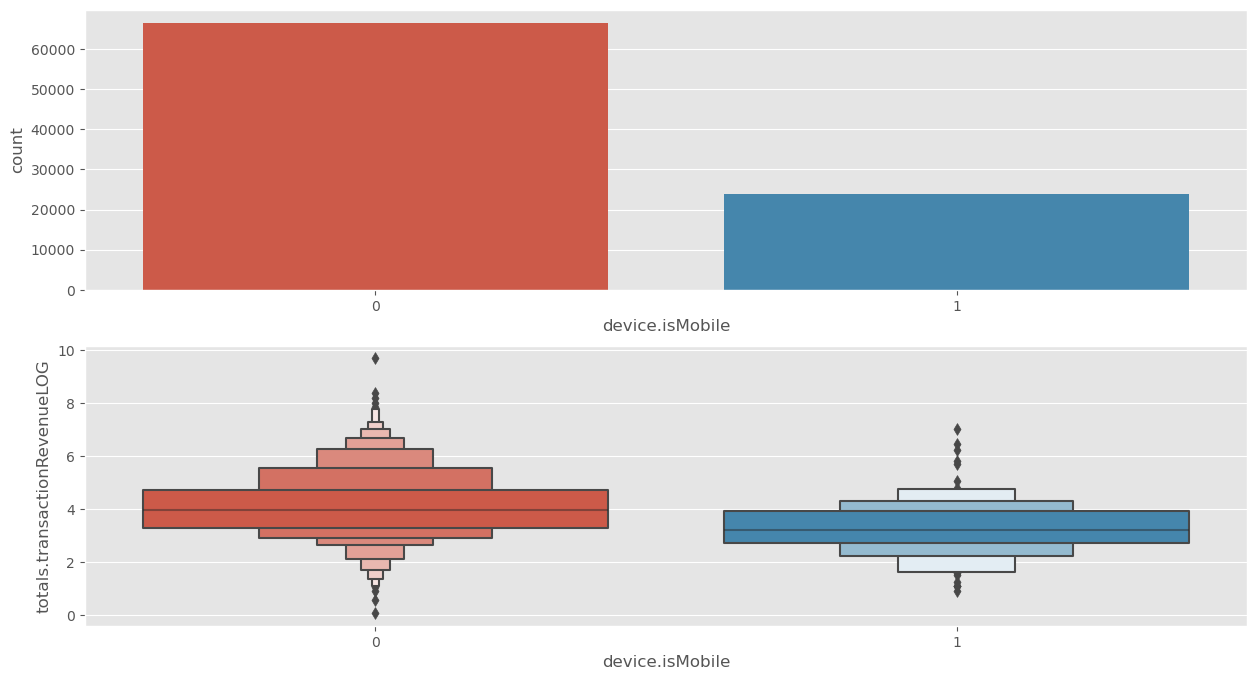

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.isMobile,,,,,
0,66496,0.737,1075,0.016,4.111491
1,23753,0.263,98,0.004,3.342780


In [123]:
cat_analysis(df, 'device.isMobile', TARGET_LOG)

#### 2.2.2.1. Total Bounces

1    45130
0    45119
Name: totals.bounces, dtype: int64


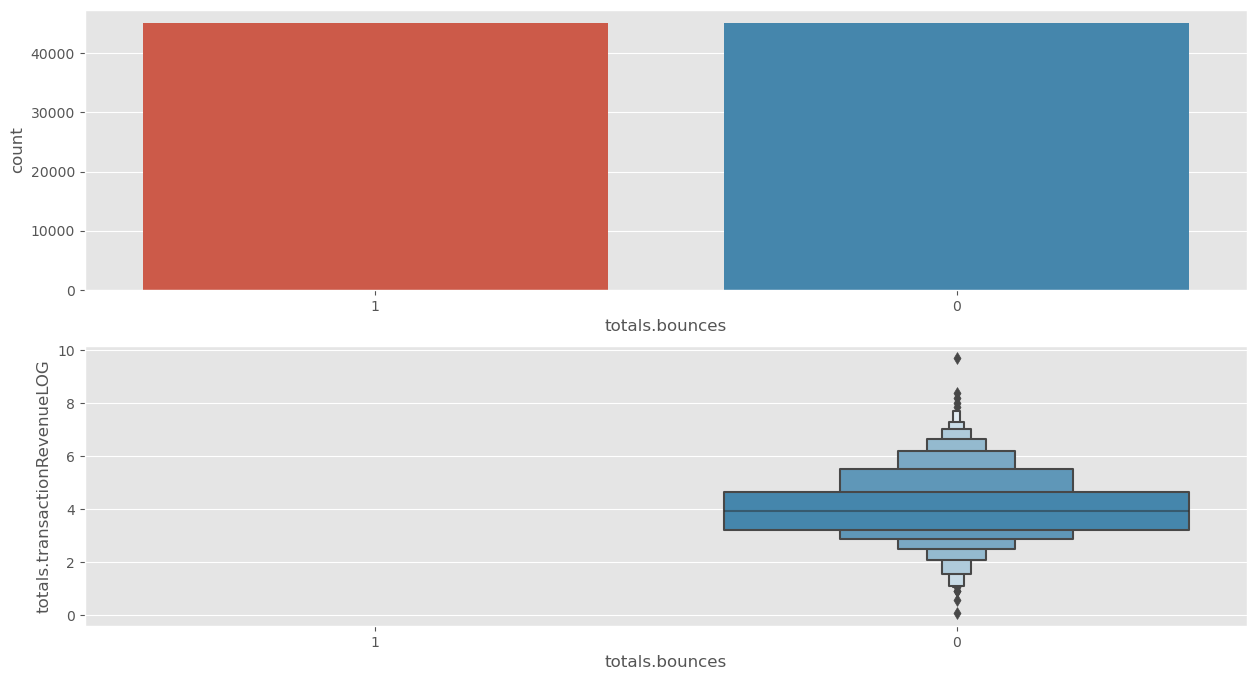

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
totals.bounces,,,,,
0,45119,0.5,1173,0.026,4.047268


In [124]:
cat_analysis(df, 'totals.bounces', TARGET_LOG)

#### 2.2.2.1. New Visits

1    69990
0    20259
Name: totals.newVisits, dtype: int64


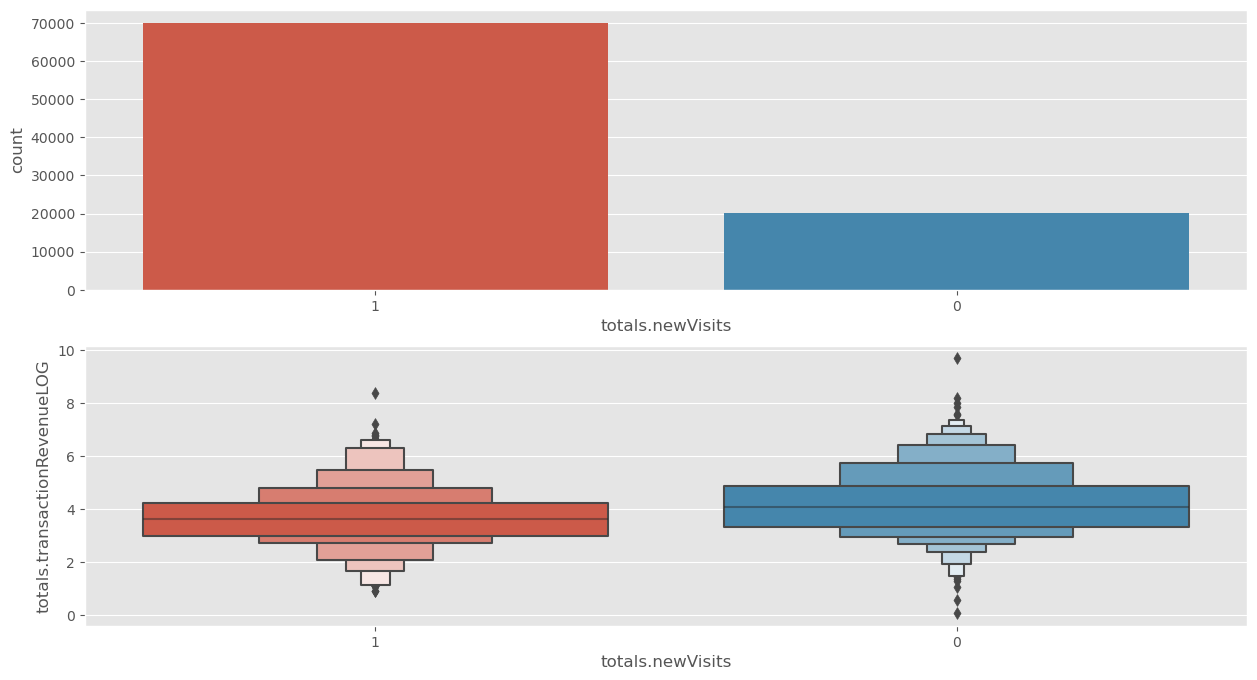

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
totals.newVisits,,,,,
0,20259,0.224,731,0.036,4.237697
1,69990,0.776,442,0.006,3.732329


In [125]:
cat_analysis(df, 'totals.newVisits', TARGET_LOG)

### 2.2.3. Category

#### 2.2.3.1. channelGrouping

In [126]:
#df.select_dtypes(exclude = 'object').describe().T
#object_cols = df.select_dtypes(exclude = 'number').columns.to_list()

Organic Search    37993
Social            22568
Direct            14178
Referral          10607
Paid Search        2599
Affiliates         1678
Display             615
(Other)              11
Name: channelGrouping, dtype: int64


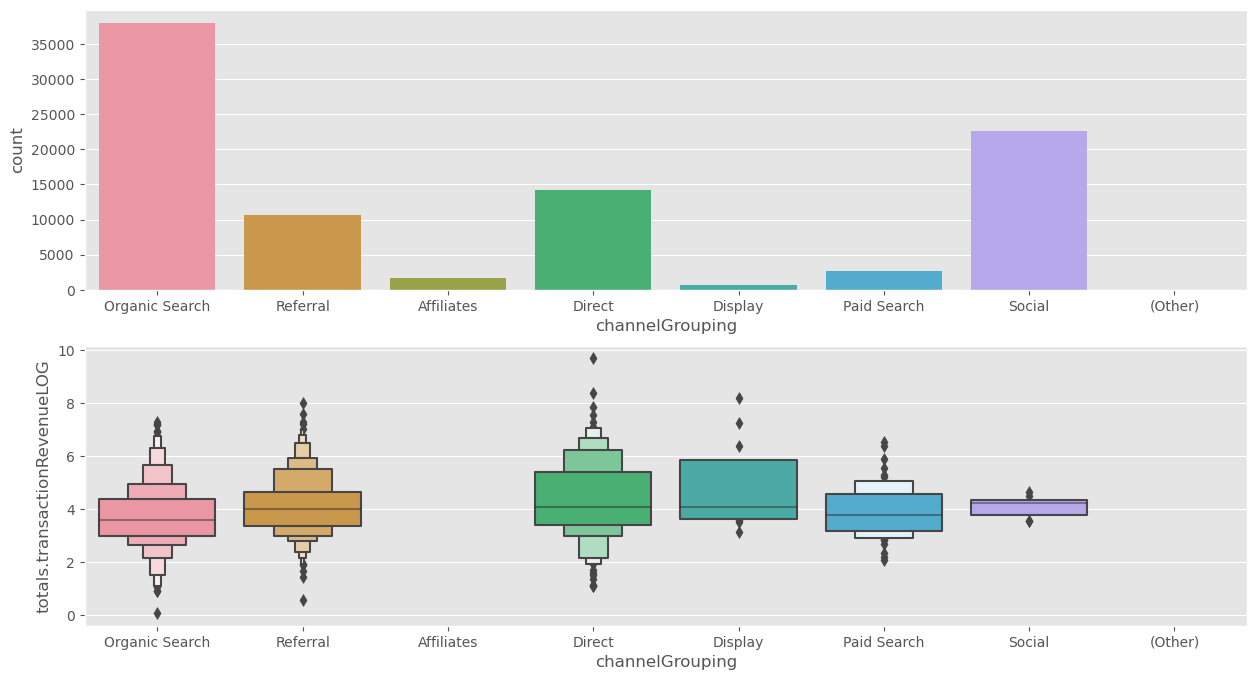

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
channelGrouping,,,,,
Direct,14178,0.157,233,0.016,4.330222
Display,615,0.007,10,0.016,4.827975
Organic Search,37993,0.421,357,0.009,3.761390
Paid Search,2599,0.029,45,0.017,3.935536
Referral,10607,0.118,519,0.049,4.110750
Social,22568,0.250,9,0.000,4.092178


In [127]:
cat_analysis(df,'channelGrouping', TARGET_LOG)

#### 2.2.3.2. Device browser

In [128]:
df['device.browser'].value_counts().head(10)

Chrome               62130
Safari               18207
Firefox               3569
Internet Explorer     1930
Edge                  1020
Android Webview        785
Safari (in-app)        661
Opera Mini             597
Opera                  558
UC Browser             230
Name: device.browser, dtype: int64

Chrome               62130
Safari               18207
Firefox               3569
Others                3393
Internet Explorer     1930
Edge                  1020
Name: device.browser, dtype: int64


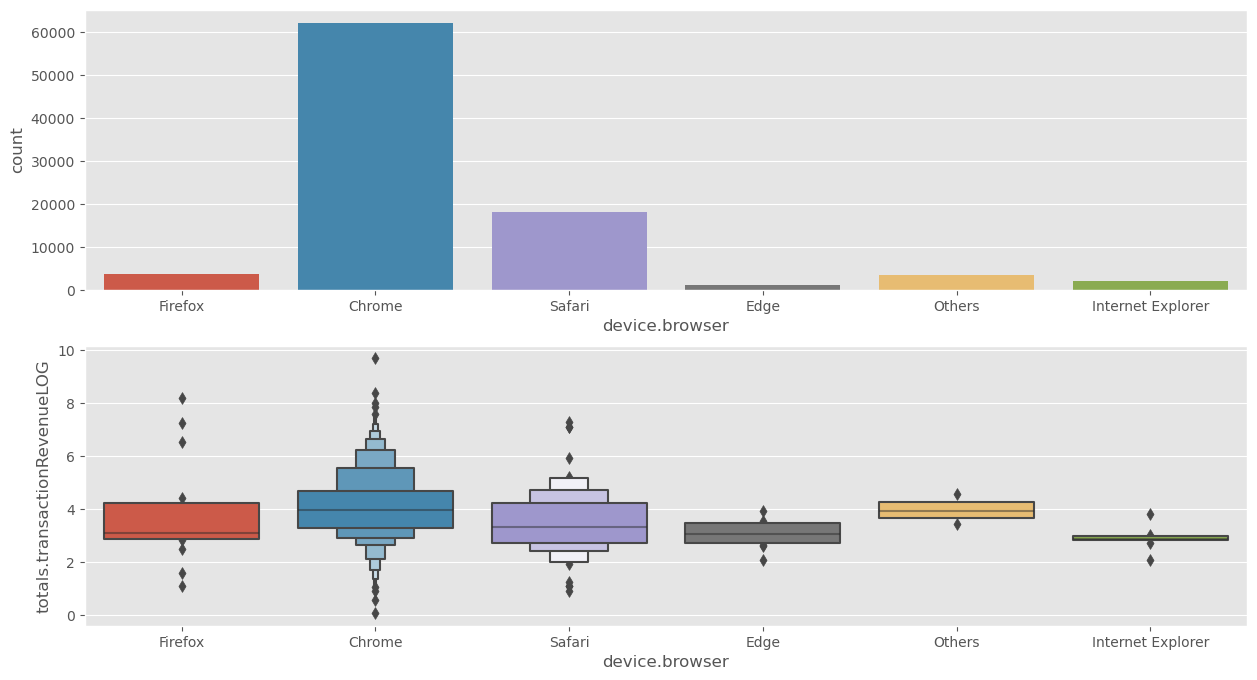

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.browser,,,,,
Chrome,62130,0.688,1062,0.017,4.104154
Safari,18207,0.202,73,0.004,3.536319
Firefox,3569,0.040,17,0.005,3.802816
Internet Explorer,1930,0.021,8,0.004,2.911421
Edge,1020,0.011,10,0.010,3.079891
Others,3393,0.038,3,0.001,3.981681


In [129]:
df['device.browser'] = setOthers(df,'device.browser',5)

cat_analysis(df, 'device.browser', TARGET_LOG)

#### 2.2.3.3. Operating System

In [130]:
df['device.operatingSystem'].value_counts()

Windows          34835
Macintosh        25592
Android          12428
iOS              10620
Linux             3461
Chrome OS         2671
(not set)          452
Windows Phone      107
BlackBerry          27
Samsung             24
Firefox OS          10
Nintendo Wii         9
Nintendo WiiU        7
Xbox                 6
Name: device.operatingSystem, dtype: int64

Windows      34835
Macintosh    25592
Android      12428
iOS          10620
Linux         3461
Others        3313
Name: device.operatingSystem, dtype: int64


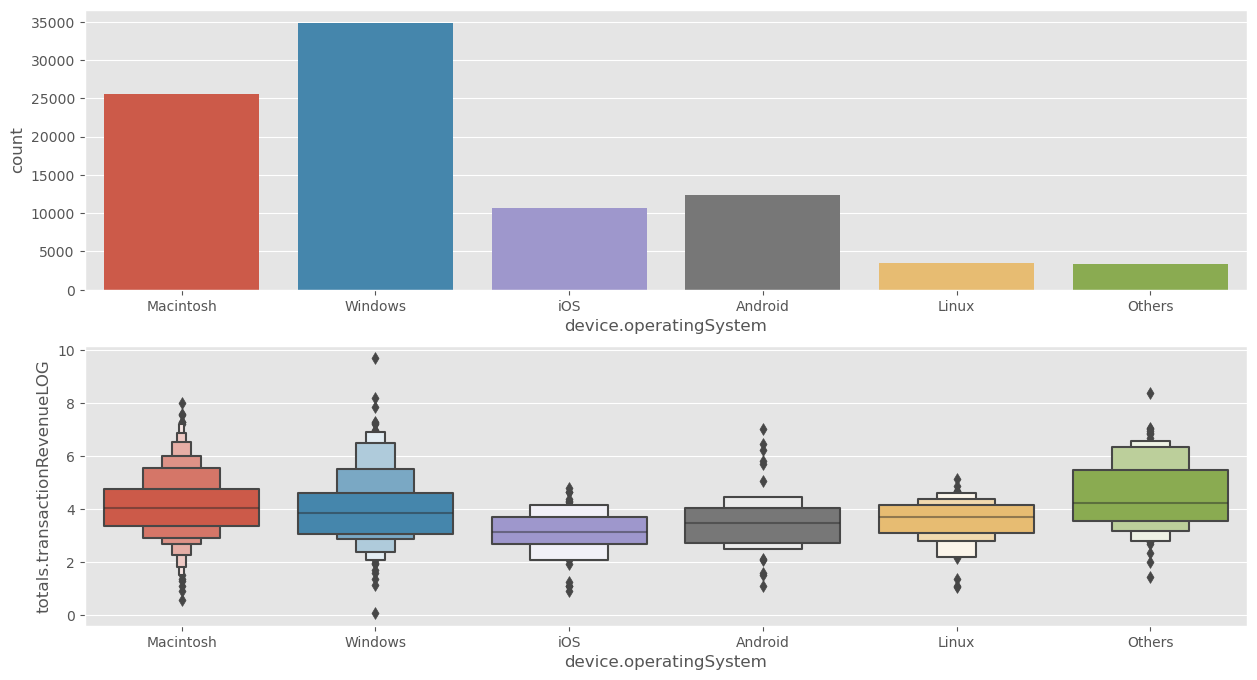

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.operatingSystem,,,,,
Windows,34835,0.386,246,0.007,4.008219
Macintosh,25592,0.284,650,0.025,4.136659
Android,12428,0.138,48,0.004,3.539950
iOS,10620,0.118,50,0.005,3.153496
Linux,3461,0.038,65,0.019,3.571798
Others,3313,0.037,114,0.034,4.498564


In [131]:
df['device.operatingSystem'] = setOthers(df,'device.operatingSystem',5)

cat_analysis(df, 'device.operatingSystem', TARGET_LOG)

#### 2.2.3.4. Device Category

desktop    66492
mobile     20743
tablet      3014
Name: device.deviceCategory, dtype: int64


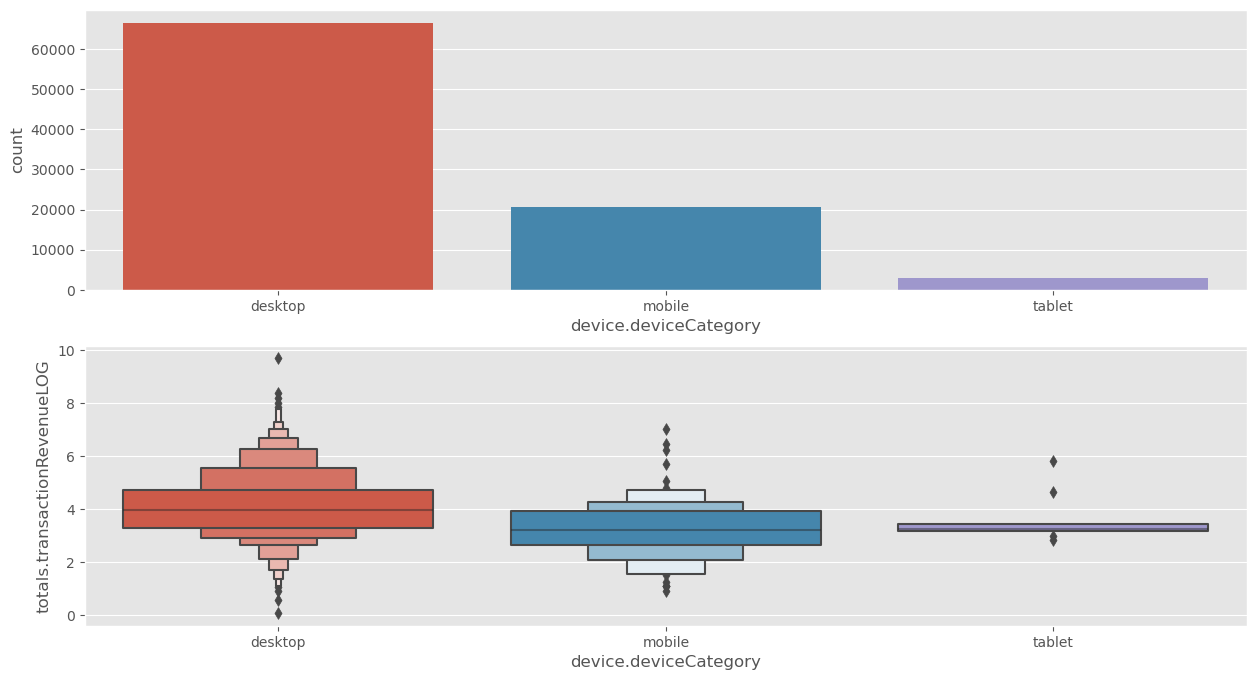

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
device.deviceCategory,,,,,
desktop,66492,0.737,1075,0.016,4.111491
mobile,20743,0.230,89,0.004,3.313351
tablet,3014,0.033,9,0.003,3.633800


In [132]:
cat_analysis(df, 'device.deviceCategory', TARGET_LOG)

#### 2.2.3.4. Network Domain

In [133]:
df['geoNetwork.networkDomain'].value_counts().head(20)

(not set)                24439
unknown.unknown          14447
comcast.net               2927
rr.com                    1500
ttnet.com.tr              1369
verizon.net               1325
comcastbusiness.net       1027
hinet.net                  795
virginm.net                657
3bb.co.th                  630
cox.net                    607
prod-infinitum.com.mx      599
sbcglobal.net              575
att.net                    534
btcentralplus.com          524
optonline.net              498
totbb.net                  492
google.com                 476
vnpt.vn                    451
asianet.co.th              445
Name: geoNetwork.networkDomain, dtype: int64

In [134]:
df['network_net'] = df['geoNetwork.networkDomain'].str.contains('.net', case=False).astype(int)
df['network_com'] = df['geoNetwork.networkDomain'].str.contains('.com', case=False).astype(int)
df['network_unknown'] = df['geoNetwork.networkDomain'].str.contains('(not set)|unknown').astype(int)
df['other_networks'] = ~df['geoNetwork.networkDomain'].str.contains('.com|.net | (not set)|unknown', case=False)
df.drop('geoNetwork.networkDomain', axis = 1, inplace = True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\483742638.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['network_unknown'] = df['geoNetwork.networkDomain'].str.contains('(not set)|unknown').astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\483742638.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['other_networks'] = ~df['geoNetwork.networkDomain'].str.contains('.com|.net | (not set)|unknown', case=False)


0    64344
1    25905
Name: network_net, dtype: int64


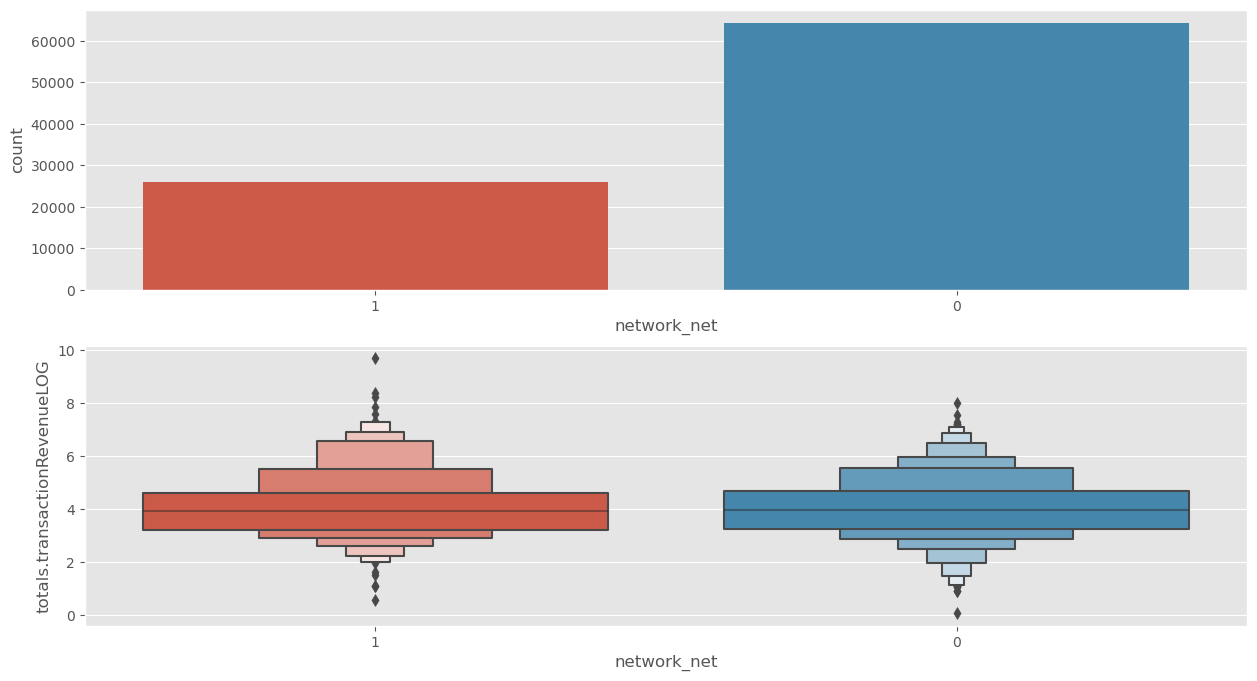

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
network_net,,,,,
0,64344,0.713,845,0.013,4.034627
1,25905,0.287,328,0.013,4.079835


In [135]:
cat_analysis(df, 'network_net', TARGET_LOG)

0    76068
1    14181
Name: network_com, dtype: int64


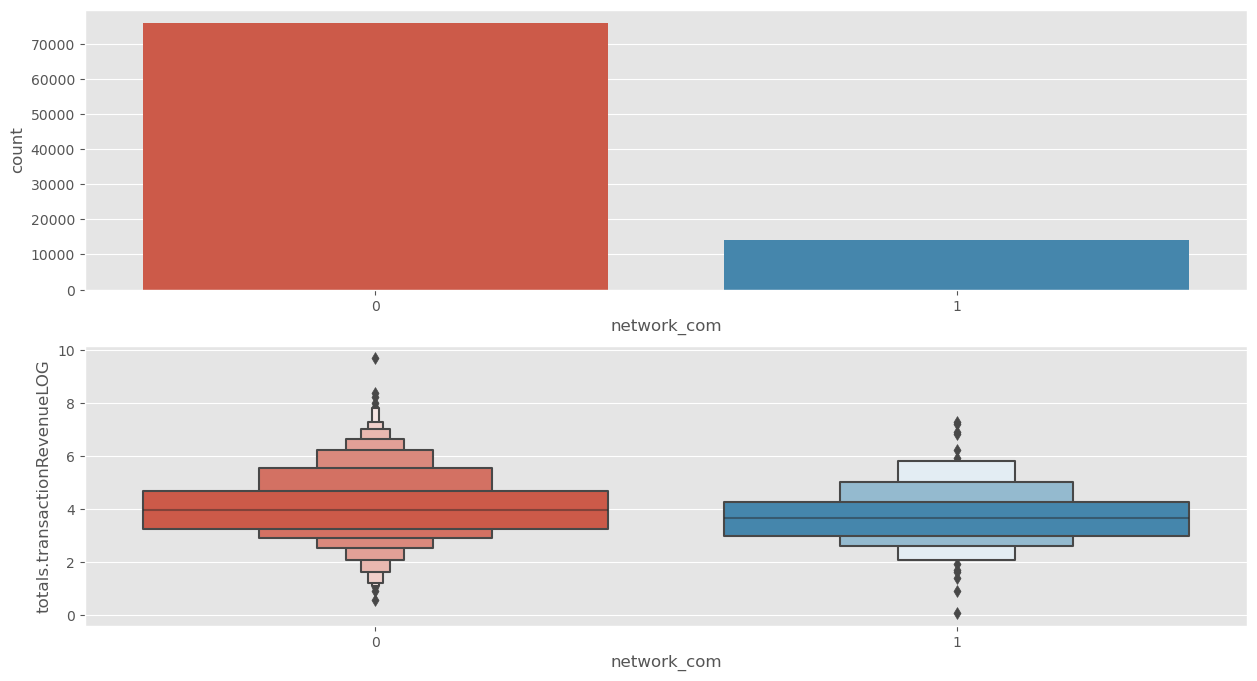

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
network_com,,,,,
0,76068,0.843,1074,0.014,4.067846
1,14181,0.157,99,0.007,3.824032


In [136]:
cat_analysis(df, 'network_com', TARGET_LOG)

In [137]:
df.describe(include = 'object').T

,count,unique,top,freq
channelGrouping,90249,8,Organic Search,37993
device.deviceCategory,90249,3,desktop,66492
geoNetwork.continent,90249,6,Americas,44972
geoNetwork.subContinent,90249,23,Northern America,39026
geoNetwork.country,90249,194,United States,36452
geoNetwork.region,90249,339,not available in demo dataset,50610
geoNetwork.metro,90249,82,not available in demo dataset,50610
geoNetwork.city,90249,546,not available in demo dataset,50610
totals.bounces,90249,2,1,45130
totals.newVisits,90249,2,1,69990


#### 2.2.3.5. Continent 

Americas     44972
Asia         22414
Europe       19627
Oceania       1564
Africa        1525
(not set)      147
Name: geoNetwork.continent, dtype: int64


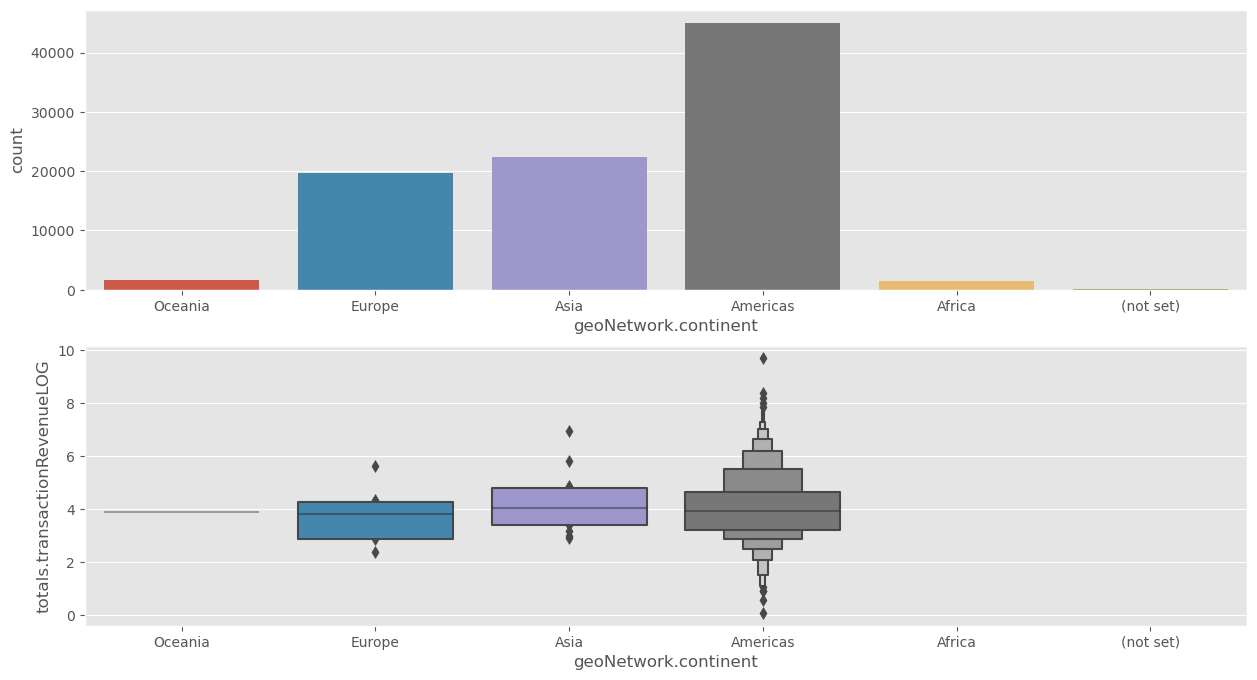

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.continent,,,,,
Americas,44972,0.498,1150,0.026,4.047594
Asia,22414,0.248,14,0.001,4.200265
Europe,19627,0.217,8,0.000,3.752246
Oceania,1564,0.017,1,0.001,3.891208


In [138]:
cat_analysis(df, 'geoNetwork.continent', TARGET_LOG)

#### 2.2.3.6. Subcontinent

In [139]:
df['geoNetwork.subContinent'].value_counts()

Northern America      39026
Southeast Asia         7842
Southern Asia          5900
Western Europe         5855
Northern Europe        5788
Eastern Asia           4691
Eastern Europe         4489
South America          4106
Western Asia           3863
Southern Europe        3495
Central America        1566
Australasia            1549
Northern Africa         802
Caribbean               274
Western Africa          263
Southern Africa         211
Eastern Africa          201
(not set)               147
Central Asia            118
Middle Africa            48
Melanesia                 9
Micronesian Region        5
Polynesia                 1
Name: geoNetwork.subContinent, dtype: int64

In [140]:
explore_cat_values(df, 'geoNetwork.subContinent', TARGET_LOG)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.subContinent,,,,,
Australasia,1549,0.017,1,0.001,3.891208
Caribbean,274,0.003,2,0.007,3.834607
Central America,1566,0.017,2,0.001,4.215953
Eastern Asia,4691,0.052,6,0.001,4.834649
Eastern Europe,4489,0.050,2,0.000,3.602458
Northern America,39026,0.432,1139,0.029,4.047505
Northern Europe,5788,0.064,3,0.001,4.059708
South America,4106,0.045,7,0.002,4.074764
Southeast Asia,7842,0.087,3,0.000,4.408122


#### 2.2.3.7. Country

United States     36452
Others            34406
India              5109
United Kingdom     3776
Canada             2568
Turkey             2069
Germany            1998
Brazil             1966
Singapore           723
Ireland             615
Israel              567
Name: geoNetwork.country, dtype: int64


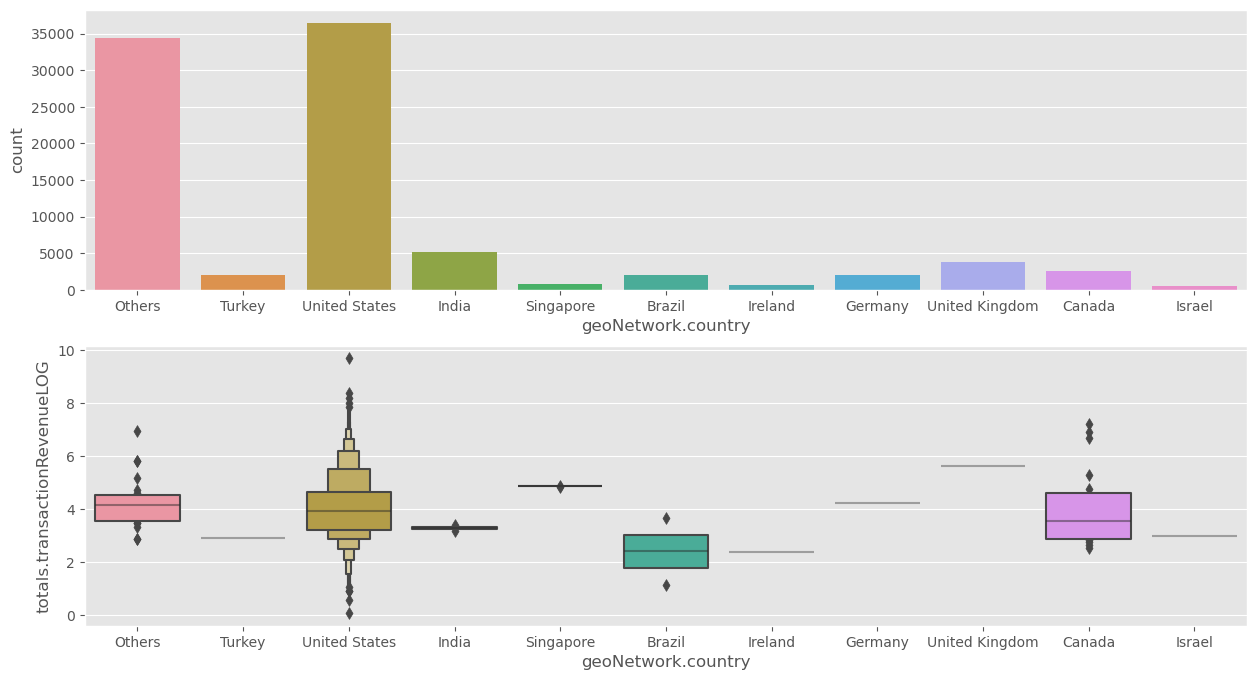

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.country,,,,,
Ireland,615,0.007,1,0.002,2.396986
Brazil,1966,0.022,2,0.001,2.406810
Turkey,2069,0.023,1,0.000,2.915606
Germany,1998,0.022,1,0.001,4.248209
Canada,2568,0.028,21,0.008,4.051605
United States,36452,0.404,1118,0.031,4.047428
United Kingdom,3776,0.042,1,0.000,5.629526
Israel,567,0.006,1,0.002,2.995232
India,5109,0.057,2,0.000,3.291962


In [141]:
df['geoNetwork.country'] = setOthersminmax(df, 'geoNetwork.country', TARGET_LOG, 500, 5)

cat_analysis(df, 'geoNetwork.country', TARGET_LOG)

#### 2.2.3.8. City

not available in demo dataset    50610
Others                           21079
Mountain View                     4095
(not set)                         3402
New York                          2593
San Francisco                     2110
Sunnyvale                         1317
London                            1261
San Jose                           982
Los Angeles                        896
Chicago                            780
Istanbul                           608
Toronto                            516
Name: geoNetwork.city, dtype: int64


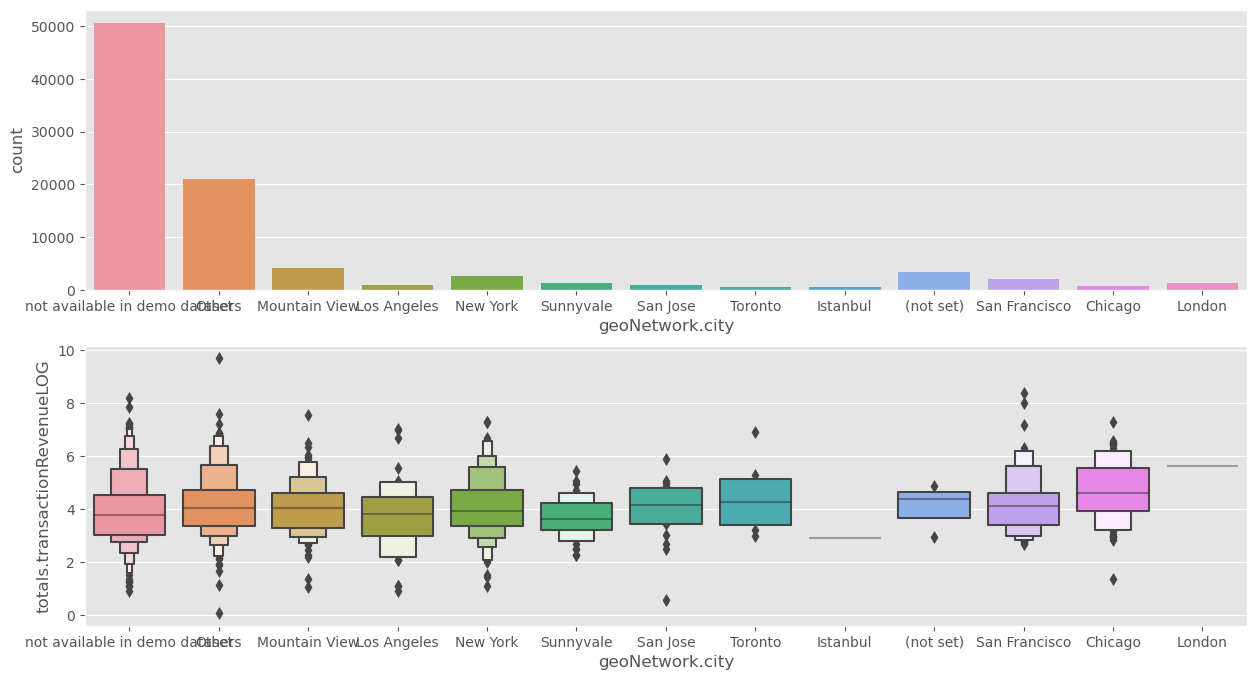

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.city,,,,,
San Jose,982,0.011,19,0.019,4.108466
Mountain View,4095,0.045,106,0.026,4.036032
Chicago,780,0.009,51,0.065,4.672854
Toronto,516,0.006,6,0.012,4.495287
Istanbul,608,0.007,1,0.002,2.915606
Sunnyvale,1317,0.015,41,0.031,3.698193
(not set),3402,0.038,3,0.001,4.068330
not available in demo dataset,50610,0.561,480,0.009,3.932934
New York,2593,0.029,158,0.061,4.060914


In [142]:
df['geoNetwork.city'] = setOthersminmax(df, 'geoNetwork.city', TARGET_LOG, 500, 10)

cat_analysis(df, 'geoNetwork.city', TARGET_LOG)

#### 2.2.3.9. Metro & Region

In [143]:
explore_cat_values(df, 'geoNetwork.metro', TARGET_LOG)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.metro,,,,,
(not set),20173,0.224,28,0.001,4.089560
Atlanta GA,235,0.003,10,0.043,4.529603
Austin TX,377,0.004,18,0.048,3.814103
Boston MA-Manchester NH,260,0.003,11,0.042,3.826383
Charlotte NC,64,0.001,1,0.016,5.967326
Chicago IL,797,0.009,51,0.064,4.672854
Dallas-Ft. Worth TX,191,0.002,3,0.016,4.319748
Denver CO,97,0.001,8,0.082,3.917023
Detroit MI,247,0.003,22,0.089,4.097004


In [144]:
explore_cat_values(df, 'geoNetwork.region', TARGET_LOG)

,n_rows,pct_rows,transactions,pct_transactions,mean_revenue_ln
geoNetwork.region,,,,,
(not set),2757,0.031,6,0.002,4.585383
Arizona,61,0.001,2,0.033,4.886998
Bucharest,151,0.002,1,0.007,4.343286
California,10820,0.120,312,0.029,4.049601
Colorado,100,0.001,8,0.080,3.917023
District of Columbia,253,0.003,8,0.032,4.746732
Dublin City,112,0.001,1,0.009,2.396986
England,1335,0.015,1,0.001,5.629526
Federal Territory of Kuala Lumpur,227,0.003,1,0.004,3.496508


In [145]:
df.drop(['geoNetwork.region', 'geoNetwork.metro'], axis = 1, inplace = True)

### 2.2.4. Numeric

#### 2.2.4.1. Totals.hits & Totals pageviews

In [146]:
df['totals.hits'].describe()

count    90249.000000
mean         4.572771
std          9.600290
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        500.000000
Name: totals.hits, dtype: float64

In [147]:
df['totals.pageviews'].describe()

count    90249.000000
mean         3.833594
std          6.996582
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max        333.000000
Name: totals.pageviews, dtype: float64

In [148]:
df[['totals.hits', 'totals.pageviews']].corr(method = 'spearman')

,totals.hits,totals.pageviews
totals.hits,1.000000,0.992029
totals.pageviews,0.992029,1.000000


In [149]:
df.drop('totals.pageviews', axis = 1, inplace = True)

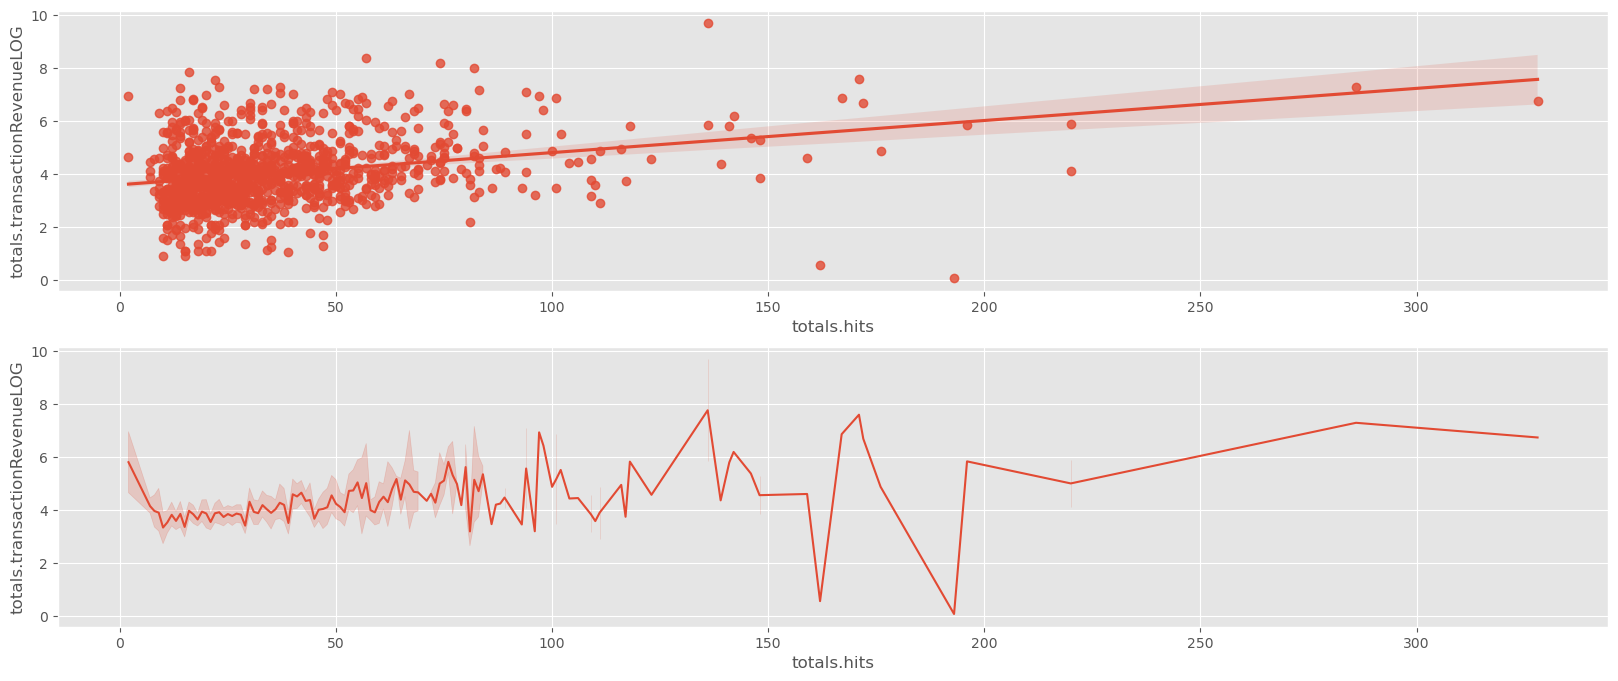

In [150]:
plot_num_values(df[df['visitWithTransaction']>0], 'totals.hits', TARGET_LOG)

In [151]:
df['totals.hits_LOG'] = df['totals.hits'].apply(lambda x: np.log1p(x))

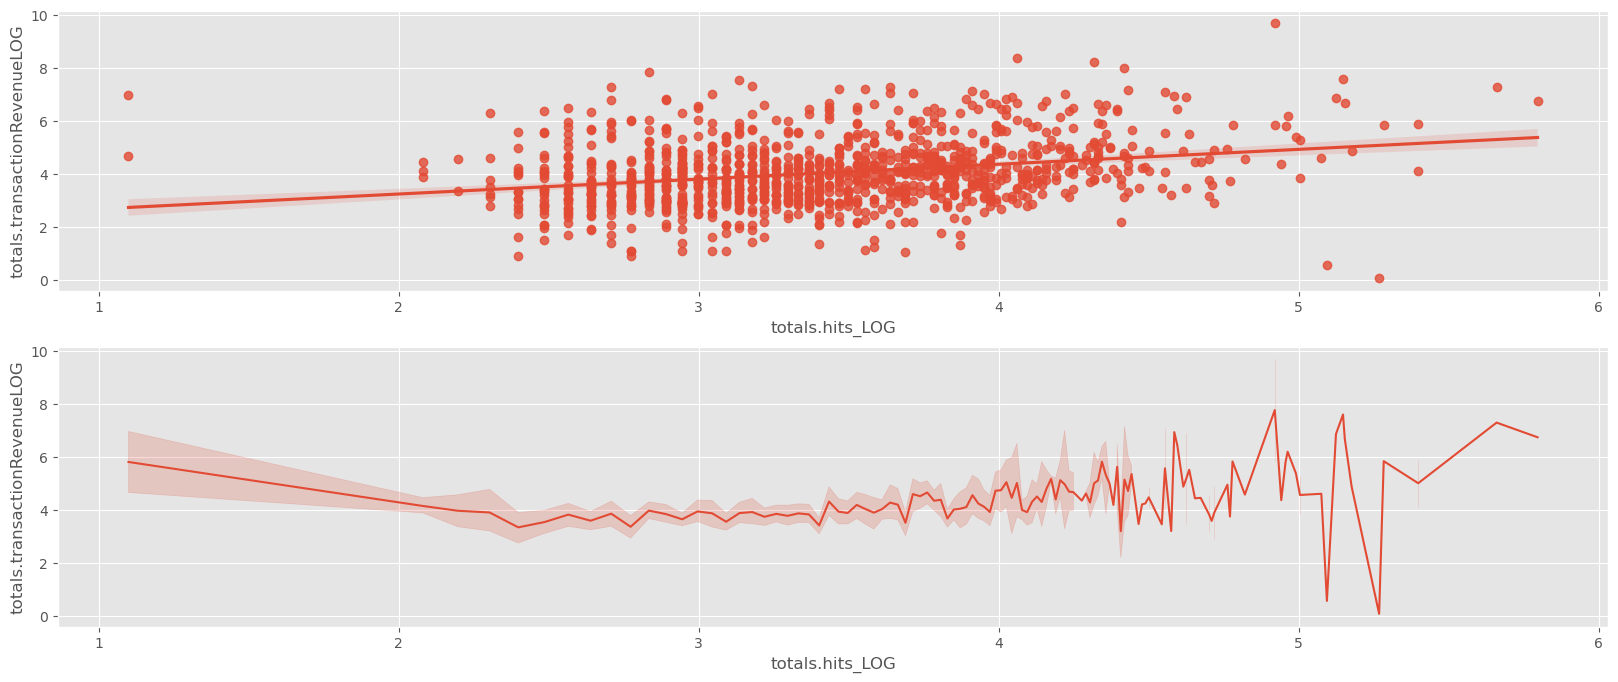

In [152]:
plot_num_values(df[df['visitWithTransaction']>0], 'totals.hits_LOG', TARGET_LOG)

#### 2.2.4.1. Visit Number

In [153]:
df['visitNumber'].describe()

count    90249.000000
mean         2.241920
std          8.800759
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        393.000000
Name: visitNumber, dtype: float64

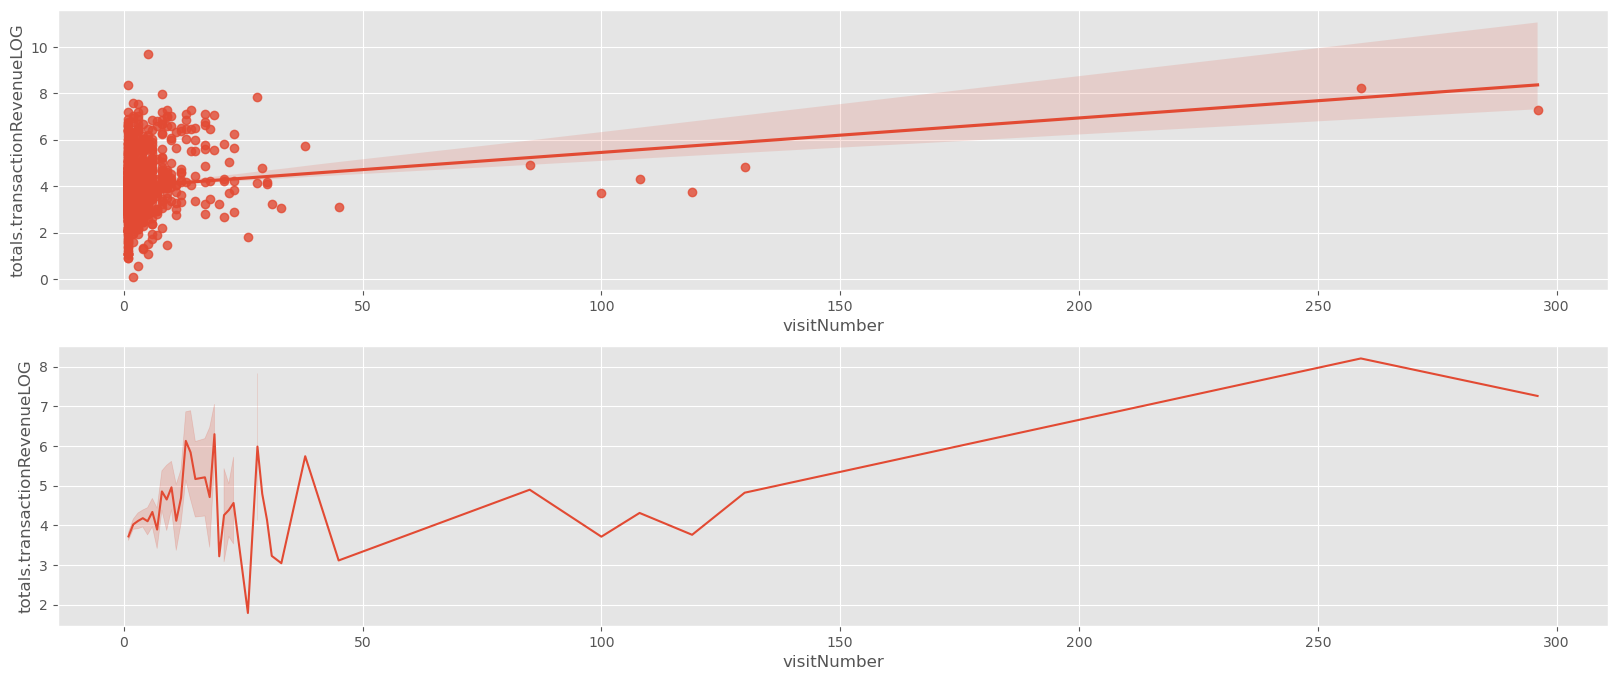

In [154]:
plot_num_values(df[df['visitWithTransaction']>0], 'visitNumber', TARGET_LOG)

In [155]:
df['visitNumber_LOG']= df['visitNumber'].apply(lambda x: np.log1p(x))

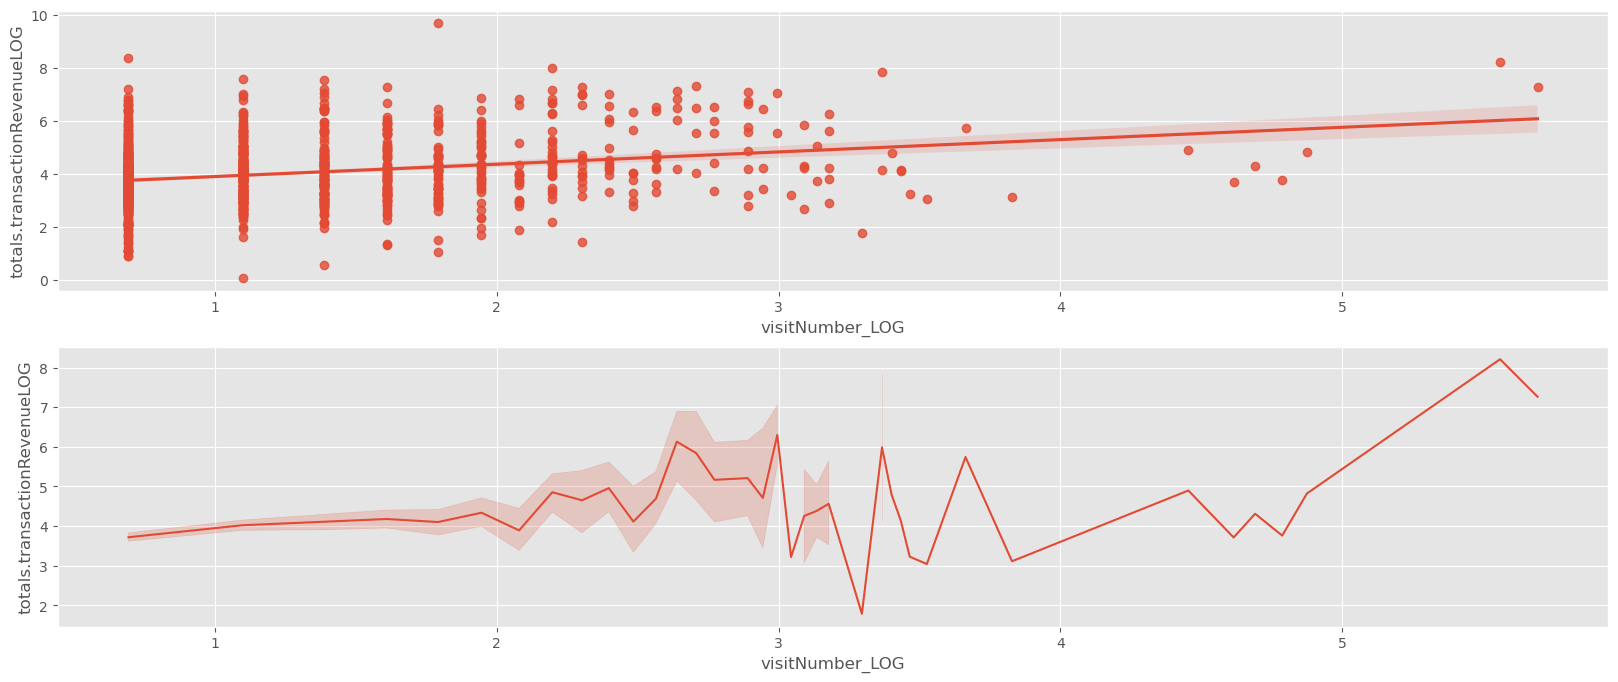

In [156]:
plot_num_values(df[df['visitWithTransaction']>0], 'visitNumber_LOG', TARGET_LOG)

In [157]:
print('Pearson:  ', df[['visitNumber_LOG', TARGET_LOG]].corr())
print('Spearman: ',df[['visitNumber_LOG', TARGET_LOG]].corr(method = 'spearman'))

Pearson:                                 visitNumber_LOG  totals.transactionRevenueLOG
visitNumber_LOG                      1.000000                      0.102183
totals.transactionRevenueLOG         0.102183                      1.000000
Spearman:                                visitNumber_LOG  totals.transactionRevenueLOG
visitNumber_LOG                       1.00000                       0.11404
totals.transactionRevenueLOG          0.11404                       1.00000


In [158]:
df.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.city', 'totals.hits', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'visitWithTransaction',
       'totals.transactionRevenueLOG', 'year', 'month', 'monthDay', 'weekDay',
       'quarter', 'week', 'visitHour', 'network_net', 'network_com',
       'network_unknown', 'other_networks', 'totals.hits_LOG',
       'visitNumber_LOG'],
      dtype='object')

In [159]:
#df.to_csv('GACR_clean.csv')

In [160]:
#df.drop(['visitNumber', 'totals.hits', 'totals.transactionRevenue', ])

# 3. Data Preparation

In [161]:
df.describe(exclude = np.number).T

,count,unique,top,freq
channelGrouping,90249,8,Organic Search,37993
device.browser,90249,6,Chrome,62130
device.operatingSystem,90249,6,Windows,34835
device.deviceCategory,90249,3,desktop,66492
geoNetwork.continent,90249,6,Americas,44972
geoNetwork.subContinent,90249,23,Northern America,39026
geoNetwork.country,90249,11,United States,36452
geoNetwork.city,90249,13,not available in demo dataset,50610
totals.bounces,90249,2,1,45130
totals.newVisits,90249,2,1,69990


In [162]:
df.select_dtypes(exclude= np.number).columns.to_list()

['channelGrouping',
 'device.browser',
 'device.operatingSystem',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.city',
 'totals.bounces',
 'totals.newVisits',
 'other_networks']

In [163]:
cat_OHE = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory', 'geoNetwork.continent']
cat_to_int = ['totals.bounces', 'totals.newVisits', 'other_networks']
cat_freq = ['geoNetwork.subContinent', 'geoNetwork.country','geoNetwork.city']
cat_to_transform = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory',
 'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.city', 'totals.bounces',
 'totals.newVisits', 'other_networks']

In [164]:
transform_cat = ColumnTransformer(transformers = [
    ('encoder', OneHotEncoder(sparse_output = False), cat_OHE),
    ('dtype_conv', FunctionTransformer(lambda x: x.astype(float)), cat_to_int),
    ('ordinal', OrdinalEncoder(),  cat_freq)
])

In [165]:
df1 = df

In [166]:
df1.columns

Index(['channelGrouping', 'visitNumber', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.city', 'totals.hits', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'visitWithTransaction',
       'totals.transactionRevenueLOG', 'year', 'month', 'monthDay', 'weekDay',
       'quarter', 'week', 'visitHour', 'network_net', 'network_com',
       'network_unknown', 'other_networks', 'totals.hits_LOG',
       'visitNumber_LOG'],
      dtype='object')

In [167]:
df1 = transform_cat.fit_transform(df1)
df = df.merge(df1, left_index = True, right_index = True)

In [168]:
df.drop(cat_to_transform, axis = 1, inplace = True)

In [169]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
visitNumber,90263.0,2.241838,8.800096,1.000000,1.000000,1.000000,1.000000,393.000000
device.isMobile,90263.0,0.263175,0.440359,0.000000,0.000000,0.000000,1.000000,1.000000
totals.hits,90263.0,4.572837,9.600086,1.000000,1.000000,2.000000,4.000000,500.000000
totals.transactionRevenue,90263.0,1.893065,64.522784,0.000000,0.000000,0.000000,0.000000,16023.750000
visitWithTransaction,90263.0,0.013040,0.113445,0.000000,0.000000,0.000000,0.000000,1.000000
totals.transactionRevenueLOG,90263.0,0.052623,0.477976,0.000000,0.000000,0.000000,0.000000,9.681890
year,90263.0,2016.515837,0.499752,2016.000000,2016.000000,2017.000000,2017.000000,2017.000000
month,90263.0,6.997829,3.488154,1.000000,4.000000,7.000000,10.000000,12.000000
monthDay,90263.0,15.736869,8.845413,1.000000,8.000000,16.000000,23.000000,31.000000
weekDay,90263.0,2.739173,1.926517,0.000000,1.000000,3.000000,4.000000,6.000000


In [170]:
GACR_cleaned = df
#GACR_cleaned.to_csv('GACR_preprocessed.csv')

In [171]:
GACR_cleaned[TARGET].median()

0.0

In [172]:
GACR_cleaned[GACR_cleaned['visitWithTransaction']>0][TARGET].median()

50.02

In [173]:
cols_to_drop = ['visitNumber', 'totals.hits','visitWithTransaction', 'totals.transactionRevenue']
df = df.drop(cols_to_drop, axis = 1)

# 4. Modelling

## 4.1. Validation strategy

In [174]:
df.groupby(['year', 'month'])[TARGET_LOG].agg(len).to_frame()

totals.transactionRevenueLOG
year month                              
2016 8                              7418
     9                              7134
     10                             9807
     11                            11306
     12                             8037
2017 1                              6506
     2                              6226
     3                              6882
     4                              6598
     5                              6543
     6                              6403
     7                              7138
     8                               265

In [175]:
df_val = df[df['year'] * 100 + df['month'] >= 201706]
df_dev = df[df['year'] * 100 + df['month'] < 201706]

In [176]:
df_val.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 13806 entries, 0000436683523507380_1500504900 to 9999594748540438502_1499262993
Columns: 49 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(38), int32(4), int64(7)
memory usage: 5.1+ MB


In [177]:
df_dev.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 76457 entries, 0000040862739425590_1486836571 to 9999978264901065827_1485325580
Columns: 49 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(38), int32(4), int64(7)
memory usage: 28.0+ MB


In [178]:
df_val_X = df_val.drop(TARGET_LOG, axis = 1)
df_val_y = df_val[[TARGET_LOG]]
df_dev_X = df_dev.drop(TARGET_LOG, axis = 1)
df_dev_y = df_dev[[TARGET_LOG]]

In [179]:
print(df_val_X.info(verbose = False))
print(df_val_y.info(verbose = False))
print(df_dev_X.info(verbose = False))
print(df_dev_y.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
Index: 13806 entries, 0000436683523507380_1500504900 to 9999594748540438502_1499262993
Columns: 48 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(37), int32(4), int64(7)
memory usage: 5.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 13806 entries, 0000436683523507380_1500504900 to 9999594748540438502_1499262993
Columns: 1 entries, totals.transactionRevenueLOG to totals.transactionRevenueLOG
dtypes: float64(1)
memory usage: 215.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 76457 entries, 0000040862739425590_1486836571 to 9999978264901065827_1485325580
Columns: 48 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(37), int32(4), int64(7)
memory usage: 27.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 76457 entries, 0000040862739425590_1486836571 to 9999978264901065827_1485325580
Columns: 1 entries, totals.transactionRevenueLOG to totals.transactionRevenueLOG
dtypes: float64(1)
memory

In [180]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state =  42,
    test_size = 0.25
)

In [181]:
print(X_train.info(verbose = False))
print(X_test.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
Index: 57342 entries, 1759779356678951325_1492014369 to 2053287982118140626_1478826630
Columns: 48 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(37), int32(4), int64(7)
memory usage: 20.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 19115 entries, 0161885435803422373_1471744647 to 8254305555506154101_1482448586
Columns: 48 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(37), int32(4), int64(7)
memory usage: 6.9+ MB
None


In [182]:
def validation_strategy(df):
    df_val = df[df['year'] * 100 + df['month'] >= 201706]
    df_dev = df[df['year'] * 100 + df['month'] < 201706]

    df_val_X = df_val.drop(TARGET_LOG, axis = 1)
    df_val_y = df_val[[TARGET_LOG]]
    df_dev_X = df_dev.drop(TARGET_LOG, axis = 1)
    df_dev_y = df_dev[[TARGET_LOG]]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state =  42,
    test_size = 0.25)
    return df

In [183]:
#validation_strategy(df)

## 4.2. Testing algorithms

### 4.2.1. Gradient Boosting

In [185]:
#def xgb_model(df):
validation_strategy(df)
xgb_model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, random_state = 42, n_estimators = 100, max_depth = 4)
xgb_model.fit(X_train, y_train, 
    eval_set = [(X_train, y_train), (df_val_X, df_val_y)], 
    verbose = True)
Y_train_predict = xgb_model.predict(X_train)
Y_valida_predict = xgb_model.predict(df_val_X)

[0]	validation_0-rmse:0.44853	validation_1-rmse:0.46471
[1]	validation_0-rmse:0.42985	validation_1-rmse:0.44949
[2]	validation_0-rmse:0.41861	validation_1-rmse:0.44140
[3]	validation_0-rmse:0.41053	validation_1-rmse:0.43763
[4]	validation_0-rmse:0.40526	validation_1-rmse:0.43409
[5]	validation_0-rmse:0.40113	validation_1-rmse:0.43265
[6]	validation_0-rmse:0.39804	validation_1-rmse:0.43320
[7]	validation_0-rmse:0.39550	validation_1-rmse:0.43231
[8]	validation_0-rmse:0.39330	validation_1-rmse:0.43167
[9]	validation_0-rmse:0.39112	validation_1-rmse:0.43331
[10]	validation_0-rmse:0.39044	validation_1-rmse:0.43381
[11]	validation_0-rmse:0.38861	validation_1-rmse:0.43404
[12]	validation_0-rmse:0.38843	validation_1-rmse:0.43420
[13]	validation_0-rmse:0.38696	validation_1-rmse:0.43422
[14]	validation_0-rmse:0.38566	validation_1-rmse:0.43442
[15]	validation_0-rmse:0.38402	validation_1-rmse:0.43352
[16]	validation_0-rmse:0.38330	validation_1-rmse:0.43431
[17]	validation_0-rmse:0.38130	validation

In [186]:
xgb_model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, random_state = 42, n_estimators = 100, max_depth = 4)

In [187]:
%%time
xgb_model.fit(X_train, y_train, 
    eval_set = [(X_train, y_train), (df_val_X, df_val_y)], 
    verbose = True)

[0]	validation_0-rmse:0.44853	validation_1-rmse:0.46471
[1]	validation_0-rmse:0.42985	validation_1-rmse:0.44949
[2]	validation_0-rmse:0.41861	validation_1-rmse:0.44140
[3]	validation_0-rmse:0.41053	validation_1-rmse:0.43763
[4]	validation_0-rmse:0.40526	validation_1-rmse:0.43409
[5]	validation_0-rmse:0.40113	validation_1-rmse:0.43265
[6]	validation_0-rmse:0.39804	validation_1-rmse:0.43320
[7]	validation_0-rmse:0.39550	validation_1-rmse:0.43231
[8]	validation_0-rmse:0.39330	validation_1-rmse:0.43167
[9]	validation_0-rmse:0.39112	validation_1-rmse:0.43331
[10]	validation_0-rmse:0.39044	validation_1-rmse:0.43381
[11]	validation_0-rmse:0.38861	validation_1-rmse:0.43404
[12]	validation_0-rmse:0.38843	validation_1-rmse:0.43420
[13]	validation_0-rmse:0.38696	validation_1-rmse:0.43422
[14]	validation_0-rmse:0.38566	validation_1-rmse:0.43442
[15]	validation_0-rmse:0.38402	validation_1-rmse:0.43352
[16]	validation_0-rmse:0.38330	validation_1-rmse:0.43431
[17]	validation_0-rmse:0.38130	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### 4.2.1.1. Model Evaluation

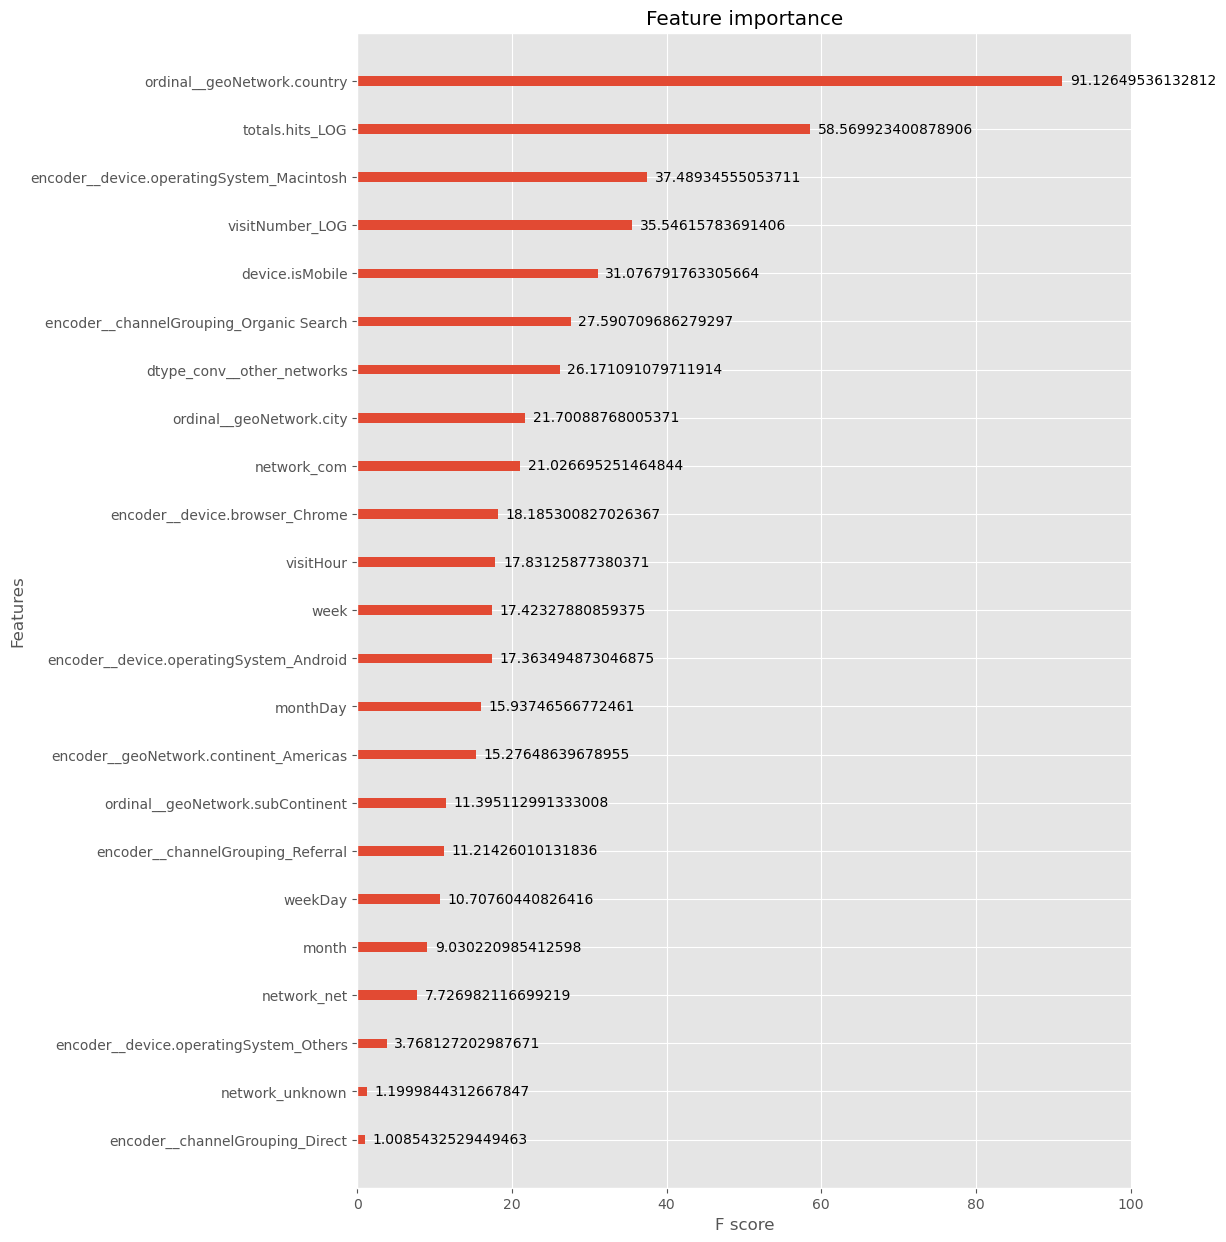

In [188]:
importance = xgb_model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(xgb_model, importance_type = "gain", ax = ax);

#### 4.2.1.2. Prediction

In [189]:
from sklearn.metrics import mean_squared_error

Y_train_predict = xgb_model.predict(X_train)
Y_valida_predict = xgb_model.predict(df_val_X)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = df_val_y,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 5)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 5)).replace(".", "_")

In [190]:
print('rmse_train: ',rmse_train)
print('rmse_valida',rmse_valida)

rmse_train:  0_3933
rmse_valida 0_43167


In [191]:
test_prediction = pd.DataFrame(xgb_model.predict(X_test), columns=['Prediction'], index=X_test.index)
results_df = y_test.join(test_prediction)
results_df.columns = ['Target', 'Prediction']
results_df['error'] = results_df['Target'] - results_df['Prediction']
results_df['squared_error'] = results_df['error'] ** 2
results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])
mse = results_df['squared_error'].mean()
rmse = results_df['rooted_squared_error'].mean()
mse_modelo_tonto = (results_df['Target'] **2).mean()
print('MSE tonto: {} - MSE: {} - RMSE: {}'.format(mse_modelo_tonto, mse, rmse))


MSE tonto: 0.20758739372564858 - MSE: 0.15863005779158504 - RMSE: 0.0754259392762845


In [192]:
val_predictions = pd.DataFrame(xgb_model.predict(df_val_X), index = df_val_X.index, columns = ['Prediction'])
val_results_df_xgb = df_val_y.join(val_predictions)
val_results_df_xgb.columns = ['Target', 'Prediction']
val_results_df_xgb['error'] = val_results_df_xgb['Target'] - val_results_df_xgb['Prediction']
val_results_df_xgb['squared_error'] = val_results_df_xgb['error'] ** 2
val_results_df_xgb['rooted_squared_error'] = np.sqrt(val_results_df_xgb['squared_error'])
val_results_df_xgb.sample(10)

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
9679233467392063713_1499975416,0.0,0.003060,-0.003060,0.000009,0.003060
5792113668119220855_1496341229,0.0,0.001148,-0.001148,0.000001,0.001148
2011718769498214932_1499233187,0.0,0.001148,-0.001148,0.000001,0.001148
1673867262392691272_1500500158,0.0,0.001148,-0.001148,0.000001,0.001148
5080682932851757501_1500884178,0.0,0.003060,-0.003060,0.000009,0.003060
5133369691904205151_1500963340,0.0,0.003060,-0.003060,0.000009,0.003060
6448555338183813090_1500726177,0.0,0.001148,-0.001148,0.000001,0.001148
2443034175234782709_1499225344,0.0,0.001148,-0.001148,0.000001,0.001148
0633711552653550557_1500491661,0.0,0.003060,-0.003060,0.000009,0.003060


In [193]:
mse_rf = val_results_df_xgb['squared_error'].mean()
rmse_rf = val_results_df_xgb['rooted_squared_error'].mean()
print('MSE: {} - RMSE: {}'.format(mse_rf, rmse_rf))

MSE: 0.18634032136240106 - RMSE: 0.08040033813098009


#### 4.2.1.3. Rebalance dataset (Undersampling)

In [194]:
df_dev_zero = df_dev[df_dev[TARGET_LOG] == 0]
df_dev_nonzero = df_dev[df_dev[TARGET_LOG] > 0]
print(df_dev_zero.info(verbose=False)
)
print(df_dev_nonzero.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
Index: 75482 entries, 0000040862739425590_1486836571 to 9999978264901065827_1485325580
Columns: 49 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(38), int32(4), int64(7)
memory usage: 27.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 975 entries, 0003450834640354121_1476825602 to 9982700667464896535_1494607165
Columns: 49 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(38), int32(4), int64(7)
memory usage: 365.6+ KB
None


In [195]:
n_nonzeros = len(df_dev_nonzero) * 3 # equivaldra a 0.25 - 0.75 aprox
n_nonzeros

2925

In [196]:
df_dev_zero_sample = df_dev_zero.sample(n = n_nonzeros, random_state = 42)
df_dev_zero_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 2863776665224623701_1479365792 to 5480931910853100032_1471212835
Data columns (total 49 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   device.isMobile                            2925 non-null   int32  
 1   totals.transactionRevenueLOG               2925 non-null   float64
 2   year                                       2925 non-null   int64  
 3   month                                      2925 non-null   int64  
 4   monthDay                                   2925 non-null   int64  
 5   weekDay                                    2925 non-null   int64  
 6   quarter                                    2925 non-null   int64  
 7   week                                       2925 non-null   int64  
 8   visitHour                                  2925 non-null   int64  
 9   network_net                                292

In [197]:
df_dev_sample = pd.concat([df_dev_nonzero, df_dev_zero_sample])
df_dev_sample.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 3900 entries, 0003450834640354121_1476825602 to 5480931910853100032_1471212835
Columns: 49 entries, device.isMobile to ordinal__geoNetwork.city
dtypes: float64(38), int32(4), int64(7)
memory usage: 1.4+ MB


In [198]:
df_dev_sample_X = df_dev_sample.drop(TARGET_LOG, axis=1)
df_dev_sample_y = df_dev_sample[[TARGET_LOG]]

In [199]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_sample_X,
    df_dev_sample_y,
    random_state = 42,
    test_size = 0.25
)

In [200]:
xgb_model_r = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, random_state = 42, n_estimators = 100, max_depth = 4)

In [201]:
%%time
xgb_model_r.fit(X_train, y_train, 
    eval_set = [(X_train, y_train), (df_val_X, df_val_y)], 
    verbose = True)

[0]	validation_0-rmse:1.45677	validation_1-rmse:0.84278
[1]	validation_0-rmse:1.22367	validation_1-rmse:0.73899
[2]	validation_0-rmse:1.08183	validation_1-rmse:0.69821
[3]	validation_0-rmse:0.99454	validation_1-rmse:0.68257
[4]	validation_0-rmse:0.94246	validation_1-rmse:0.68290
[5]	validation_0-rmse:0.91020	validation_1-rmse:0.68206
[6]	validation_0-rmse:0.88645	validation_1-rmse:0.68490
[7]	validation_0-rmse:0.87070	validation_1-rmse:0.69077
[8]	validation_0-rmse:0.85618	validation_1-rmse:0.69364
[9]	validation_0-rmse:0.84687	validation_1-rmse:0.69313
[10]	validation_0-rmse:0.83732	validation_1-rmse:0.69441
[11]	validation_0-rmse:0.83150	validation_1-rmse:0.69488
[12]	validation_0-rmse:0.82313	validation_1-rmse:0.69645
[13]	validation_0-rmse:0.82075	validation_1-rmse:0.69603
[14]	validation_0-rmse:0.80898	validation_1-rmse:0.69658
CPU times: total: 1.06 s
Wall time: 301 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [202]:
Y_train_predict = xgb_model_r.predict(X_train)
Y_valida_predict = xgb_model_r.predict(df_val_X)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = df_val_y,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 5)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 5)).replace(".", "_")

In [203]:
print('rmse_train: ',rmse_train)
print('rmse_valida',rmse_valida)

rmse_train:  0_9102
rmse_valida 0_68206


In [205]:
val_predictions_XGB = pd.DataFrame(xgb_model_r.predict(df_val_X), index = df_val_X.index, columns = ['Prediction'])
val_results_df_xgb_r = df_val_y.join(val_predictions_XGB)
val_results_df_xgb_r.columns = ['Target', 'Prediction']
val_results_df_xgb_r['error'] = val_results_df_xgb_r['Target'] - val_results_df_xgb_r['Prediction']
val_results_df_xgb_r['squared_error'] = val_results_df_xgb_r['error'] ** 2
val_results_df_xgb_r['rooted_squared_error'] = np.sqrt(val_results_df_xgb_r['squared_error'])
val_results_df_xgb_r

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
0000436683523507380_1500504900,0.0,0.116897,-0.116897,0.013665,0.116897
0000618629079057366_1497262860,0.0,0.116897,-0.116897,0.013665,0.116897
0000712751584756636_1497866155,0.0,0.116897,-0.116897,0.013665,0.116897
0001399220722808057_1500076255,0.0,0.116897,-0.116897,0.013665,0.116897
000170187170673177_1497108503,0.0,0.259171,-0.259171,0.067170,0.259171
...,...,...,...,...,...
9997226733716451773_1497514991,0.0,0.116897,-0.116897,0.013665,0.116897
9999060951673041740_1497850297,0.0,0.116897,-0.116897,0.013665,0.116897
9999252426441855495_1496517154,0.0,0.116897,-0.116897,0.013665,0.116897


In [206]:
test_prediction = pd.DataFrame(xgb_model_r.predict(X_test), columns=['Prediction'], index=X_test.index)
results_df = y_test.join(test_prediction)
results_df.columns = ['Target', 'Prediction']
results_df['error'] = results_df['Target'] - results_df['Prediction']
results_df['squared_error'] = results_df['error'] ** 2
results_df['rooted_squared_error'] = np.sqrt(results_df['squared_error'])
mse = results_df['squared_error'].mean()
rmse = results_df['rooted_squared_error'].mean()
mse_modelo_tonto = (results_df['Target'] **2).mean()
print('MSE tonto: {} - MSE: {} - RMSE: {}'.format(mse_modelo_tonto, mse, rmse))

MSE tonto: 5.07381090365442 - MSE: 1.171941098390215 - RMSE: 0.5948869991074123


In [207]:
val_predictions = pd.DataFrame(xgb_model_r.predict(df_val_X), index = df_val_X.index, columns = ['Prediction'])
val_results_df = df_val_y.join(val_predictions)
val_results_df.columns = ['Target', 'Prediction']
val_results_df['error'] = val_results_df['Target'] - val_results_df['Prediction']
val_results_df['squared_error'] = val_results_df['error'] ** 2
val_results_df['rooted_squared_error'] = np.sqrt(val_results_df['squared_error'])
val_results_df

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
0000436683523507380_1500504900,0.0,0.116897,-0.116897,0.013665,0.116897
0000618629079057366_1497262860,0.0,0.116897,-0.116897,0.013665,0.116897
0000712751584756636_1497866155,0.0,0.116897,-0.116897,0.013665,0.116897
0001399220722808057_1500076255,0.0,0.116897,-0.116897,0.013665,0.116897
000170187170673177_1497108503,0.0,0.259171,-0.259171,0.067170,0.259171
...,...,...,...,...,...
9997226733716451773_1497514991,0.0,0.116897,-0.116897,0.013665,0.116897
9999060951673041740_1497850297,0.0,0.116897,-0.116897,0.013665,0.116897
9999252426441855495_1496517154,0.0,0.116897,-0.116897,0.013665,0.116897


In [208]:
mse_xgb_v = val_results_df['squared_error'].mean()
rmse_xgb_v = val_results_df['rooted_squared_error'].mean()
print('MSE: {} - RMSE: {}'.format(mse_xgb_v, rmse_xgb_v))

MSE: 0.46520044649632425 - RMSE: 0.30819092843264495


### 4.2.2. Linear Regression

In [209]:
#non_normal_attributes = ['totals.hits_LOG', 'visitNumber_LOG']

In [210]:
#X_train_LR = X_train.drop(non_normal_attributes, axis = 1)
#df_val_X_LR = df_val_X.drop(non_normal_attributes, axis = 1)

In [211]:
lr_model = LinearRegression(positive = True)

In [212]:
%%time
lr_model.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 25 ms


LinearRegression(positive=True)

#### 4.2.2.1. Prediction

In [213]:
Y_train_predict = lr_model.predict(X_train)
Y_valida_predict = lr_model.predict(df_val_X)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = df_val_y,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 5)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 5)).replace(".", "_")

print('rmse_train: ',rmse_train)
print('rmse_valida',rmse_valida)

rmse_train:  1_06668
rmse_valida 0_88993


In [214]:
val_predictions_LR = pd.DataFrame(lr_model.predict(df_val_X), index = df_val_X.index, columns = ['Prediction'])
val_results_df_linreg = df_val_y.join(val_predictions_LR)
val_results_df_linreg.columns = ['Target', 'Prediction']
val_results_df_linreg['error'] = val_results_df_linreg['Target'] - val_results_df_linreg['Prediction']
val_results_df_linreg['squared_error'] = val_results_df_linreg['error'] ** 2
val_results_df_linreg['rooted_squared_error'] = np.sqrt(val_results_df_linreg['squared_error'])
val_results_df_linreg

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
0000436683523507380_1500504900,0.0,0.107639,-0.107639,0.011586,0.107639
0000618629079057366_1497262860,0.0,-0.777477,0.777477,0.604470,0.777477
0000712751584756636_1497866155,0.0,0.228249,-0.228249,0.052097,0.228249
0001399220722808057_1500076255,0.0,0.728555,-0.728555,0.530793,0.728555
000170187170673177_1497108503,0.0,0.986775,-0.986775,0.973725,0.986775
...,...,...,...,...,...
9997226733716451773_1497514991,0.0,0.011429,-0.011429,0.000131,0.011429
9999060951673041740_1497850297,0.0,0.023502,-0.023502,0.000552,0.023502
9999252426441855495_1496517154,0.0,0.652578,-0.652578,0.425858,0.652578


In [215]:
mse_linreg = val_results_df_linreg['squared_error'].mean()
rmse_linreg = val_results_df_linreg['rooted_squared_error'].mean()
print('MSE: {} - RMSE: {}'.format(mse_linreg, rmse_linreg))

MSE: 0.7919669978484901 - RMSE: 0.5594652102715103


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\3291953600.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Axes: xlabel='rooted_squared_error', ylabel='Density'>

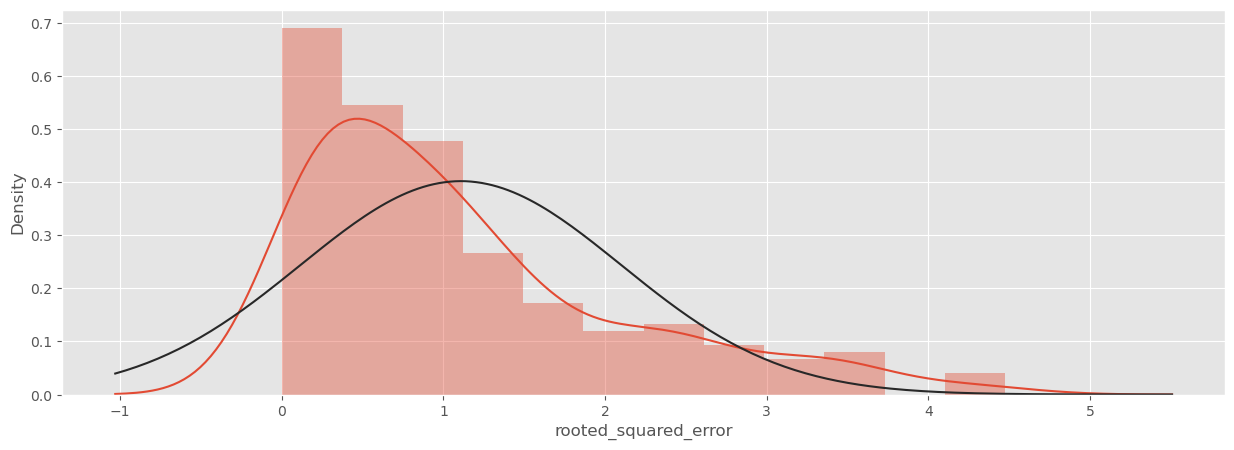

In [216]:
plt.figure(figsize=(15,5))
sns.distplot(
    val_results_df_linreg[val_results_df_linreg['Target'] > 0]['rooted_squared_error'],
    fit=stats.norm
)

### 4.2.1. Random Forest Regressor

In [217]:
rfr_model = RandomForestRegressor()

In [218]:
%%time
rfr_model.fit(X_train, y_train)

<timed eval>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: total: 594 ms
Wall time: 1.53 s


RandomForestRegressor()

In [219]:
val_predictions_rf = pd.DataFrame(rfr_model.predict(df_val_X), index = df_val_X.index, columns = ['Prediction'])
val_results_df_rf = df_val_y.join(val_predictions_rf)
val_results_df_rf.columns = ['Target', 'Prediction']
val_results_df_rf['error'] = val_results_df_rf['Target'] - val_results_df_rf['Prediction']
val_results_df_rf['squared_error'] = val_results_df_rf['error'] ** 2
val_results_df_rf['rooted_squared_error'] = np.sqrt(val_results_df_rf['squared_error'])
val_results_df_rf.sample(10)

,Target,Prediction,error,squared_error,rooted_squared_error
sessionId,,,,,
775541227392008001_1501620600,0.0,0.000000,0.000000,0.000000,0.000000
3156577002642929802_1498575715,0.0,0.000000,0.000000,0.000000,0.000000
9087400090096093141_1496675620,0.0,0.482248,-0.482248,0.232563,0.482248
1011009937391678896_1497526275,0.0,0.000000,0.000000,0.000000,0.000000
961434857915435718_1499318090,0.0,0.195593,-0.195593,0.038257,0.195593
849663625521435155_1500427668,0.0,1.123914,-1.123914,1.263182,1.123914
0232674161893068388_1496783846,0.0,0.000000,0.000000,0.000000,0.000000
3362776858163814059_1497577392,0.0,0.000000,0.000000,0.000000,0.000000
2330180175560600034_1498749909,0.0,0.219622,-0.219622,0.048234,0.219622


In [220]:
mse_rf = val_results_df_rf['squared_error'].mean()
rmse_rf = val_results_df_rf['rooted_squared_error'].mean()
print('MSE: {} - RMSE: {}'.format(mse_rf, rmse_rf))

MSE: 0.5190651374730949 - RMSE: 0.22233731168545703


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12964\2053281826.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<Axes: xlabel='rooted_squared_error', ylabel='Density'>

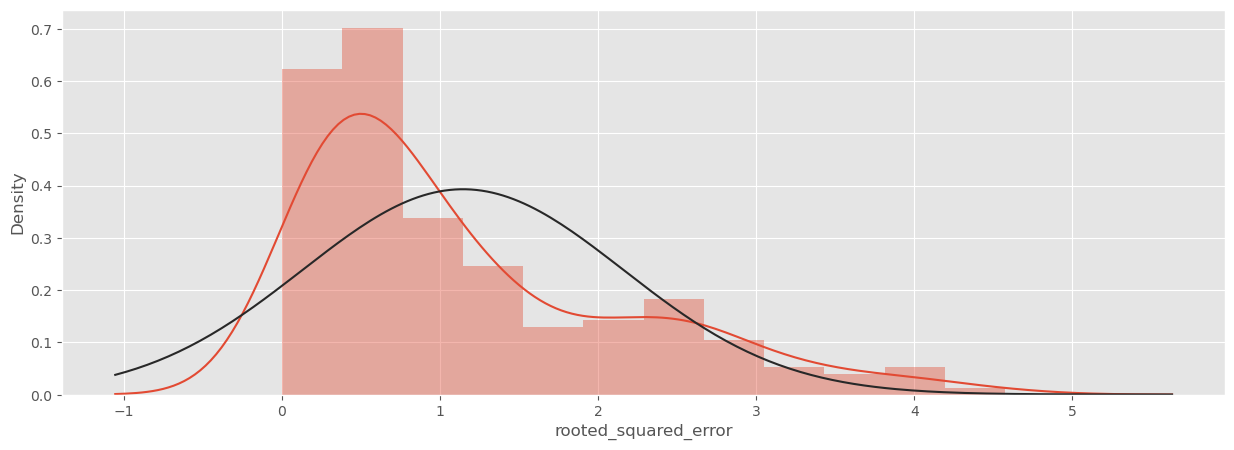

In [221]:
plt.figure(figsize=(15,5))
sns.distplot(
    val_results_df_rf[val_results_df_rf['Target'] > 0]['rooted_squared_error'],
    fit=stats.norm
)